In [2]:
import pickle
import sys
import numpy as np
import pandas as pd
import artm
import seaborn as sns
import matplotlib.pyplot as plt
print artm.version()

from os import path, mkdir
from datetime import datetime
sys.path.insert(0, '..\\modules\\helpers')
import distances_helper as dh 
from plot_helper import PlotMaker
from config_helper import ConfigPaths
from print_helper import PrintHelper
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
from scipy.optimize import minimize
from sklearn.metrics.pairwise import cosine_distances
from numpy.linalg import norm as euclidean_norm

0.8.1


In [3]:
config = ConfigPaths('config_sample_m3.cfg')
print config.models_file_name
models_file = open(config.models_file_name, 'a')

plot_maker = PlotMaker()
printer = PrintHelper()

batch_vectorizer = artm.BatchVectorizer(data_path=config.output_batches_path,
                                        data_format='batches')
dictionary = artm.Dictionary()
dictionary.load(dictionary_path=config.dictionary_path + '.dict')

Q:\\topic_modeling\\csi_science_collections.git\experiments\pn_model3\np_07_02_m3_convex\models.txt


In [15]:
def create_model(current_dictionary, n_topics, n_doc_passes, seed_value, n_top_tokens, p_mass_threshold, _debug_print=False):    
    if _debug_print:
        print '[{}] creating model'.format(datetime.now())
    model = artm.ARTM(num_topics=n_topics, dictionary=current_dictionary, cache_theta=True, seed=seed_value, 
                  class_ids={'@default_class': 1.0})
    model.num_document_passes = n_doc_passes
    add_scores_to_model(model, n_top_tokens=n_top_tokens, p_mass_threshold=p_mass_threshold)
    return model
def add_scores_to_model(artm_model, n_top_tokens, p_mass_threshold, _debug_print=False):
    if _debug_print:
        print '[{}] adding scores'.format(datetime.now())
    artm_model.scores.add(artm.PerplexityScore(name='perplexity_score',
                                      dictionary=dictionary))
    artm_model.scores.add(artm.SparsityPhiScore(name='ss_phi_score', class_id='@default_class'))
    artm_model.scores.add(artm.SparsityThetaScore(name='ss_theta_score'))
    artm_model.scores.add(artm.TopicKernelScore(name='topic_kernel_score', class_id='@default_class', 
                                                probability_mass_threshold=p_mass_threshold))
    artm_model.scores.add(artm.TopTokensScore(name='top_tokens_score', class_id='@default_class', num_tokens=n_top_tokens))
def fit_one_model(model, _n_iterations, _model_name='', _debug_print=False): 
    if _debug_print:
        print '[{}] fitting'.format(datetime.now())
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=_n_iterations)
    if _debug_print:
        print '[{}] outputting'.format(datetime.now())
    printer.print_artm_model(model, _model_name, _n_iterations, output_file=models_file)
    model_pics_file_name =  path.join(config.experiment_path, _model_name)
    plot_maker.make_tm_plots(model, model_pics_file_name)
    model_output_file_name = path.join(config.experiment_path, _model_name + '.txt')
    printer.print_scores(model, _model_name, _n_iterations, model_output_file_name)
    printer.print_top_tokens(model, model_output_file_name)
    return model
def save_pickle_file(dists, filename, _path=config.experiment_path):
    pickle_filename = path.join(_path, filename)
    pickle_file = open(pickle_filename, 'wb')
    pickle.dump(dists, pickle_file)
    pickle_file.close()
def save_model_pickle(_model_name, _model, _save=True):
    phi = _model.get_phi()
    phi = phi[(phi.T != 0).any()]
    theta = _model.get_theta()    
    saved_top_tokens = _model.score_tracker['top_tokens_score'].last_tokens
    if _save:
        save_pickle_file(phi, 'phi_{}.p'.format(_model_name))
        save_pickle_file(theta, 'theta_{}.p'.format(_model_name))
        save_pickle_file(saved_top_tokens, 'saved_top_tokens_{}.p'.format(_model_name))
    return phi, theta, saved_top_tokens
def load_pickle_file(filename, _path=config.experiment_path):
    pickle_filename = path.join(_path, filename)
    pickle_file = open(pickle_filename, 'rb')
    p_file = pickle.load(pickle_file)
    pickle_file.close()
    return p_file
def load_model_pickle(_model_name, _distance_name=None, _path=config.experiment_path):
    phi = load_pickle_file('phi_{}.p'.format(_model_name), _path)
    theta = load_pickle_file('theta_{}.p'.format(_model_name), _path)
    saved_top_tokens = load_pickle_file('saved_top_tokens_{}.p'.format(_model_name), _path)
    distances = None
    if _distance_name is not None:
        distances = load_pickle_file('{}.p'.format(_distance_name), _path)
    return phi, theta, saved_top_tokens, distances

def calculate_distances(dist_fun, _phi, _phi_other, _debug_print=False):
    if _debug_print:
        print '[{}] take_distances between {} columns and {} columns'.format(datetime.now(), len(_phi.columns), len(_phi_other.columns))
    distances = pd.DataFrame(0, index = _phi.columns, columns=_phi_other.columns)
    for idx, col in enumerate(_phi.columns):
        if _debug_print and idx % 20 == 0:
            print '[{}] column {} / {}'.format(datetime.now(), idx, len(_phi.columns))
        for idx_other, col_other in enumerate(_phi_other.columns):
            distance = dist_fun(_phi[col], _phi_other[col_other])
            distances.iloc[idx, idx_other] = distance
    return distances
def get_optimization_result_one_matrix(dist_fn, jac_dist_fn, phi, distances, _debug_print=False):
    opt_results = {}
    for col_idx, col_name in enumerate(phi.columns):
        if _debug_print and col_idx % 20 == 0:
            print '[{}] get_optimization_result for column {} / {}'.format(datetime.now(), col_idx, len(phi.columns))
        column = phi[col_name]
        # delete col from phi
        phi_cut = phi.drop(col_name, axis=1)
        opt_results[col_name] = solve_optimization_problem(dist_fn, jac_dist_fn, column, col_name, phi_cut, distances)
    return opt_results
def get_optimization_result(dist_fn, jac_dist_fn, phi, phi_other, distances, _debug_print=False):
    opt_results = {}
    for col_idx, col_name in enumerate(phi.columns):
        if _debug_print and col_idx % 20 == 0:
            print '[{}] get_optimization_result for column {} / {}'.format(datetime.now(), col_idx, len(phi.columns))        
        column = phi[col_name]
        opt_results[col_name] = solve_optimization_problem(dist_fn, jac_dist_fn, column, col_name, phi_other, distances)
    return opt_results
def solve_optimization_problem(dist_fn, jac_dist_fn, column, column_name, phi, distances, max_iter=7, verbose=False):
    max_iter = 50
    phi_columns = phi.columns
    # cut distances by phi columns 
    cut_distances = distances[phi_columns]
    # get n closest topics
    closest_column_names = cut_distances.loc[column_name].sort_values().head(N_CLOSEST_TOPICS).index.values
    phi_closest = phi[closest_column_names]
    
    # opt solver
    n_columns = phi_closest.shape[1] 
    bnds = [(0, 1)] * n_columns
    constraints = cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1, 'jac': lambda x: [1] * n_columns})
    opt_fun = lambda x: dist_fn(column, phi_closest.dot(x))
    jac_fun = lambda x: jac_dist_fn(column, phi_closest, x)
    
    is_optimized = False
    it = 0
    while (not is_optimized) and it != max_iter:
        it += 1
        init_x = np.random.uniform(0, 1, (1, n_columns))
        init_x /= np.sum(init_x)
        if jac_dist_fn is not None:
            res = minimize(opt_fun, jac=jac_fun, x0=init_x, method='SLSQP', bounds=bnds, constraints=cons, options={'maxiter': max_iter, 'disp': verbose})
        else:
            res = minimize(opt_fun, x0=init_x, method='SLSQP', bounds=bnds, constraints=cons, options={'maxiter': max_iter, 'disp': verbose})
        is_optimized = res.success
    if not is_optimized:
        print('Column {} not optimized'.format(column_name))         
    res['column_names'] = phi_closest.columns
    res['optimized_column'] = column_name
#     res['projection'] = phi_closest.dot(res.x)
#     res['column'] = column
    return res

Загрузим оригинальный sample датасет (от model3), до этого скопировав в папку с batches нужные pickle файлы модели.
Сначала провизуалируем по одной итерации каждой новой модели, а потом будем итерационно строить выпуклую оболочку для каждой модели по отдельности и затем сравнивать их. 

In [8]:
phi_original, theta_original, saved_top_tokens_original, distances_hellinger_model_original = load_model_pickle('model3', 'distances_hellinger_model3', config.output_batches_path)
print phi_original.shape, theta_original.shape

(2216, 100) (100, 3446)


Запустить несколько раз с разным рандомом. Следить за тем, чтобы накапливались только независимые темы. Каждый раз смотреть. как проектируется на оригинальную матрицу.

In [14]:
def create_model_fn_1(n_iteration):
    tmp_model = create_model(current_dictionary=dictionary, n_topics=20, n_doc_passes=5, seed_value=100 + n_iteration,
                             n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = fit_one_model(tmp_model, _n_iterations=20, _model_name='model_20_m1_iter_{}'.format(n_iteration))
    return tmp_model
def create_model_fn_2(n_iteration):
    tmp_model = create_model(current_dictionary=dictionary, n_topics=100, n_doc_passes=5, seed_value=100 + n_iteration,
                             n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model = fit_one_model(tmp_model, _n_iterations=20, _model_name='model_100_m2_iter_{}'.format(n_iteration))
    return tmp_model
def create_model_fn_3(n_iteration):
    tmp_model = create_model(current_dictionary=dictionary, n_topics=20, n_doc_passes=5, seed_value=100 + n_iteration,
                            n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 300
    tmp_model.regularizers['ss_theta_regularizer'].tau = -5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -20
    tmp_model = fit_one_model(tmp_model, _n_iterations=20, _model_name='model_20_m3_iter_{}'.format(n_iteration))
    return tmp_model
def create_model_fn_4(n_iteration):
    tmp_model = create_model(current_dictionary=dictionary, n_topics=100, n_doc_passes=5, seed_value=100 + n_iteration,
                            n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 10
    tmp_model.regularizers['ss_theta_regularizer'].tau = -0.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -2
    tmp_model = fit_one_model(tmp_model, _n_iterations=20, _model_name='model_20_m4_iter_{}'.format(n_iteration))
    return tmp_model
def filter_convex_hull(phi_convex_hull, get_topics_to_remove_fn, max_iteration=10):
    distances_model_iter = calculate_distances(dh.hellinger_dist, phi_convex_hull, phi_convex_hull)
    iterations_info = []
    for n_iteration in range(max_iteration):
        print('[{}] filtering iteration = {} / {}'.format(datetime.now(), n_iteration + 1, max_iteration))
        # get new opts results
        opt_res_convex_hull_inter = get_optimization_result_one_matrix(dh.hellinger_dist, None, 
                                                                       phi_convex_hull, distances_model_iter)
        # get topics to remove
        topics_to_remove, not_removed_topics_count = get_topics_to_remove_fn(opt_res_convex_hull_inter, distances_model_iter)
        # update phi convex
        phi_convex_hull = remove_topics_from_phi(phi_convex_hull, topics_to_remove)
        distances_model_iter = remove_topics_from_distances_xy(distances_model_iter, topics_to_remove)
        iterations_info.append({'it': n_iteration,
                                'n_topics_to_remove': len(topics_to_remove),
                                'phi_convex_hull_shape': phi_convex_hull.shape,
                                'removed_topics': topics_to_remove,
                                'not_removed_topics_count': not_removed_topics_count,
#                                 'phi_convex_hull': phi_convex_hull, 
                                'opt_res': opt_res_convex_hull_inter})
        print('[{}] {} topics to remove, {} not_removed_topics_count because close topics, current convex_hull shape = {}'.format(datetime.now(), 
               iterations_info[-1]['n_topics_to_remove'], not_removed_topics_count, iterations_info[-1]['phi_convex_hull_shape']))
        if len(iterations_info) >= 2 and iterations_info[-1]['n_topics_to_remove'] == 0 and iterations_info[-2]['n_topics_to_remove'] == 0:
            print('[{}] topics to remove not increasing, breaking the for loop'.format(datetime.now()))
            break
    return phi_convex_hull, iterations_info
def build_convex_hull_with_filtering(create_model_fn, get_topics_to_remove_fn, words,
                      init_convex_hull, start_iteration, max_iteration):
    # init phi of convex hull
    phi_convex_hull = init_convex_hull
    if len(phi_convex_hull) == 0:
        phi_convex_hull = pd.DataFrame(0, index = words, columns=[])
    iterations_info = []
    for n_iteration in range(start_iteration, start_iteration + max_iteration):
        print('[{}] ********** iteration = {} / {}'.format(datetime.now(), n_iteration + 1, start_iteration + max_iteration))
        # build model
        model = create_model_fn(n_iteration)
        phi = model.get_phi()
        # rename phi columns 
        phi.columns = [c + '_{}'.format(n_iteration) for c in phi.columns]
        # add to convex hull
        phi_convex_hull_expanded = pd.concat([phi_convex_hull, phi], axis=1)
        # filter topics 
        phi_convex_hull, iterations_info_filter = filter_convex_hull(phi_convex_hull_expanded, get_topics_to_remove_fn,
                                                                     max_iteration=15)
        iterations_info.append({'it': n_iteration,
                                'phi_convex_hull_shape': phi_convex_hull.shape,
                                'phi_convex_hull_columns': phi_convex_hull.columns,
#                                 'phi_convex_hull': phi_convex_hull,
                                'iterations_info_filter': iterations_info_filter
                               })
        print('[{}] current convex_hull shape = {}'.format(datetime.now(), 
               iterations_info[-1]['phi_convex_hull_shape']))
    return phi_convex_hull, iterations_info, []
def build_convex_hull_delayed_filtering(create_model_fn, get_topics_to_remove_fn, words,
                      init_convex_hull, start_iteration, max_iteration, filtering_iteration):
    # init phi of convex hull
    phi_convex_hull = init_convex_hull
    if len(phi_convex_hull) == 0:
        phi_convex_hull = pd.DataFrame(0, index = words, columns=[])
    iterations_info, iterations_info_filter_list = [], []
    for n_iteration in range(start_iteration, start_iteration + max_iteration):
        print('[{}] ********** iteration = {} / {}'.format(datetime.now(), n_iteration + 1, start_iteration + max_iteration))
        # build model
        model = create_model_fn(n_iteration)
        phi = model.get_phi()
        # rename phi columns 
        phi.columns = [c + '_{}'.format(n_iteration) for c in phi.columns]
        # add to convex hull
        phi_convex_hull = pd.concat([phi_convex_hull, phi], axis=1)
        # filter topics 
        iterations_info.append({'it': n_iteration,
                                'phi_convex_hull_shape': phi_convex_hull.shape})
        print('[{}] current convex_hull shape = {}'.format(datetime.now(), 
               iterations_info[-1]['phi_convex_hull_shape']))
        if (n_iteration + 1) % filtering_iteration == 0: 
            phi_convex_hull, iterations_info_filter = filter_convex_hull(phi_convex_hull, get_topics_to_remove_fn,
                                                                 max_iteration=150)
            iterations_info_filter_list.append(iterations_info_filter)
    return phi_convex_hull, iterations_info, iterations_info_filter_list
def get_topics_to_remove_by_opt_fun_and_distance(opt_res, distances, n_closest=N_CLOSEST_TOPICS):
    small_dist_opts = {k:i for k, i in opt_res.iteritems() if i['fun'] < OPT_FUN_THRESHOLD}
    sorted_by_fun = sorted(small_dist_opts.values(), key = lambda opt: opt['fun'])
    topics_to_remove = []
    not_removed_count = 0 
    for opt_res in sorted_by_fun:
        topic_name = opt_res.optimized_column
        # check not close to current topics to remove
        is_close_fn = lambda topic, other_topic: other_topic in distances[topic].sort_values().head(n_closest).index
        is_close_to_topics_to_remove = [is_close_fn(topic_name, t) for t in topics_to_remove]
        is_close_to_topics_to_remove = True in is_close_to_topics_to_remove 
        if not is_close_to_topics_to_remove:
            topics_to_remove.append(topic_name)
        else:
            not_removed_count += 1 
    return topics_to_remove, not_removed_count
def get_topics_to_remove_by_opt_fun(opt_res, distances, n_closest=N_CLOSEST_TOPICS):
    small_dist_opts = {k:i for k, i in opt_res.iteritems() if i['fun'] < OPT_FUN_THRESHOLD}
    topics_to_remove = [x['optimized_column'] for x in small_dist_opts.values()]
    not_removed_count = 0
    return topics_to_remove, not_removed_count
def get_topics_to_remove_by_opt_fun_single(opt_res, distances, n_closest=N_CLOSEST_TOPICS):
    small_dist_opts = {k:i for k, i in opt_res.iteritems() if i['fun'] < OPT_FUN_THRESHOLD}
    topics_to_remove = [x['optimized_column'] for x in small_dist_opts.values()][0:1]
    not_removed_count = 0
    return topics_to_remove, not_removed_count
def remove_topics_from_phi(phi, topics_to_remove):
    return phi.drop(topics_to_remove, axis=1)
def remove_topics_from_distances_x(distances, topics_to_remove):
    distances_convex_hull = distances.drop(topics_to_remove, axis=0)
    return distances_convex_hull
def remove_topics_from_distances_xy(distances, topics_to_remove):
    distances_convex_hull = distances.drop(topics_to_remove, axis=1)
    distances_convex_hull = distances_convex_hull.drop(topics_to_remove, axis=0)
    return distances_convex_hull

In [10]:
# now some info from run
# distibution of topics in convex hull by iteration
def plot_convex_hull_topics_iterations_distribution(_phi_convex_hull):
    get_iteration_number_fn = lambda x: int(x[x.find('_', 6) + 1 : ])
    phi_convex_hull_iteration_number = [get_iteration_number_fn(col) for col in _phi_convex_hull.columns]
    phi_convex_hull_iteration_number = [(val, phi_convex_hull_iteration_number.count(val), 1.0 * phi_convex_hull_iteration_number.count(val) / len(phi_convex_hull_iteration_number)) for val in set(phi_convex_hull_iteration_number)]
    print(phi_convex_hull_iteration_number)
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    sns.barplot([x[0] for x in phi_convex_hull_iteration_number], [x[1] for x in phi_convex_hull_iteration_number], ax=ax1)
    ax1.set_title('Number of topics from each iteration')
    ax1.set_xlabel('n iteration')

    sns.barplot([x[0] for x in phi_convex_hull_iteration_number], [x[2] for x in phi_convex_hull_iteration_number], ax=ax2)
    ax2.set_title('Number of topics from each iteration (%)')
    ax2.set_xlabel('n iteration')
def plot_convex_hull_columns_change(iterations_info):
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    ax1.plot([sum([val['n_topics_to_remove']for val in it['iterations_info_filter']]) for it in iterations_info], 
             color='r', label = 'total')
    ax1.set_title('Num columns to remove')
    get_topic_iteration_fn = lambda x: int(x[x.rfind('_') + 1 :])
    get_topic_filter_iteration_list_fn = lambda x, y: [get_topic_iteration_fn(topic) for topic in x].count(y)
    n_topics_removed_from_current_iteration = [sum([get_topic_filter_iteration_list_fn(val['removed_topics'], indx) for val in it['iterations_info_filter']]) for indx, it in enumerate(iterations_info)]
    ax1.plot(n_topics_removed_from_current_iteration, color='b', label='current iteration')
    ax1.set_xlabel('n iteration')
    ax1.legend()

    ax2.plot([val['phi_convex_hull_shape'][1] for val in iterations_info], color='r')
    ax2.set_title('Num columns of convex hull')
    ax2.set_xlabel('n iteration')
    ax2.legend()
def plot_opt_res_fun(iterations_filtering_info_name):
    %matplotlib inline
    iterations_filtering_info = load_pickle_file(iterations_filtering_info_name)
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    values = [x.fun for item in iterations_filtering_info for val in item for x in val['opt_res'].values()]
    sns.distplot(values, color='r', bins=10, ax=ax1)
    values = [[x.fun for val in item for x in val['opt_res'].values()] for item in iterations_filtering_info]
    for val in values:
        sns.distplot(val, bins=10, ax=ax2)
def plot_opt_res_fun_filtering(iterations_filtering_info_name):
    iterations_info = load_pickle_file(iterations_filtering_info_name)
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    values = [x.fun for item in iterations_info for val in item['iterations_info_filter'] for x in val['opt_res'].values()]
    sns.distplot(values, color='r', bins=10, ax=ax1)
    values = [[x.fun for val in item['iterations_info_filter'] for x in val['opt_res'].values()] for item in iterations_info]
    for val in values:
        sns.distplot(val, bins=10, ax=ax2)

Попробовать несколько стратегий:
1. Запустить n раз построение модели и накопить n_topics * n тем. Затем запустить фильтрацию.
2. Запустить n раз построение модели, на каждом шаге производить фильтрацию.

TODO: 
- попробовать другой метод оптимизации; другие методы из этой библиотеки не подходят, так как либо они не допускают ограничения- равенства, либо что ещё
- увеличить число повторов (?)
- сохранять результат: для каждого шага сохранять названия тем, расстояния, топ слова (а нужно ли?)


In [11]:
N_CLOSEST_TOPICS = 15

# build_convex_hull_delayed_filtering

[2017-02-07 11:42:12.621000] ********** iteration = 1 / 150
name = model_20_m1_iter_0, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25

[2017-02-07 11:42:24.411000] current convex_hull shape = (2216, 20)
[2017-02-07 11:42:24.411000] ********** iteration = 2 / 150
name = model_20_m1_iter_1, n_topics = 20, n_doc_passes = 5, seed_value = 101, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25

[2017-02-07 11:42:35.859000] current convex_hull shape = (2216, 40)
[2017-02-07 11:42:35.859000] ********** iteration = 3 / 150
name = model_20_m1_iter_2, n_topics = 20, n_doc_passes = 5, seed_value = 102, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25

[2017-02-07 11:42:46.581000] current convex_hull shape = (2216, 60)
[2017-02-07 11:42:46.582000] ********** iteration = 4 / 150
name = model_20_m1_iter_3, n_topics = 20, n_doc_passes = 5, seed_value = 103, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25

[2017-02-07 

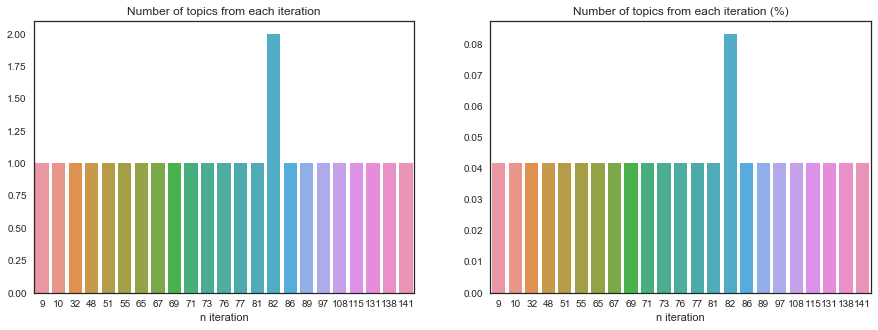

In [19]:
OPT_FUN_THRESHOLD = 0.6
phi_convex_hull_1, iterations_info_1, iterations_filtering_info_1 = build_convex_hull_delayed_filtering(create_model_fn_1, get_topics_to_remove_by_opt_fun_and_distance, 
                                                      phi_original.index,
                                                      init_convex_hull=[], start_iteration=0,
                                                      max_iteration=150, filtering_iteration=150)
%matplotlib inline
plot_convex_hull_topics_iterations_distribution(phi_convex_hull_1)
save_pickle_file(phi_convex_hull_1, 'phi_convex_hull_1')

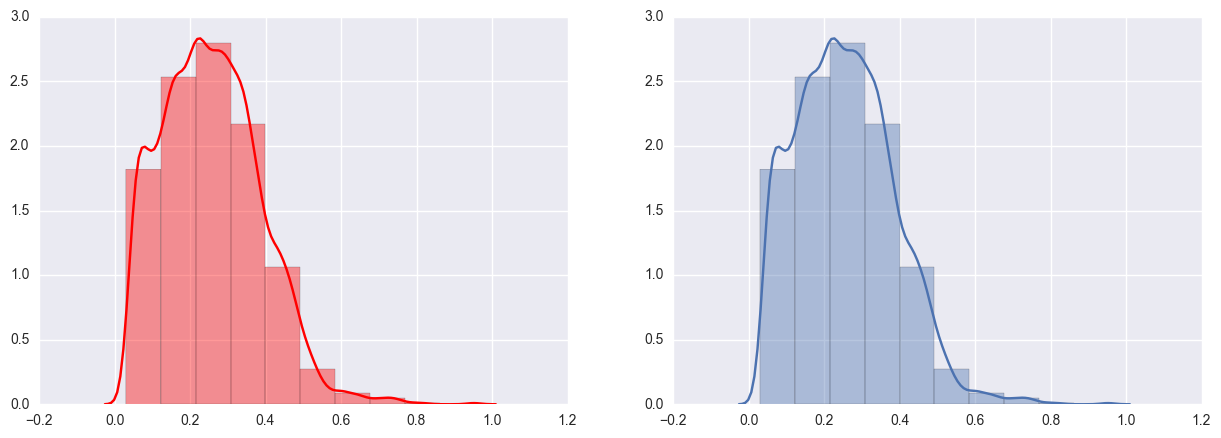

In [8]:
plot_opt_res_fun('iterations_filtering_info_1')

In [9]:
N_CLOSEST_TOPICS = 15
OPT_FUN_THRESHOLD = 0.6
phi_convex_hull_2, iterations_info_2, iterations_filtering_info_2 = build_convex_hull_delayed_filtering(create_model_fn_2, get_topics_to_remove_by_opt_fun_and_distance, 
                                                     phi_original.index,
                                                     init_convex_hull=[], start_iteration=0,
                                                     max_iteration=40, filtering_iteration=10)
plot_convex_hull_topics_iterations_distribution(phi_convex_hull_2)
save_pickle_file(phi_convex_hull_2, 'phi_convex_hull_2')

[2017-02-07 20:40:58.115000] ********** iteration = 1 / 40
name = model_100_m2_iter_0, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25

[2017-02-07 20:41:21.792000] current convex_hull shape = (2216, 100)
[2017-02-07 20:41:21.792000] ********** iteration = 2 / 40
name = model_100_m2_iter_1, n_topics = 100, n_doc_passes = 5, seed_value = 101, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25

[2017-02-07 20:41:46.124000] current convex_hull shape = (2216, 200)
[2017-02-07 20:41:46.124000] ********** iteration = 3 / 40
name = model_100_m2_iter_2, n_topics = 100, n_doc_passes = 5, seed_value = 102, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25

[2017-02-07 20:42:09.893000] current convex_hull shape = (2216, 300)
[2017-02-07 20:42:09.893000] ********** iteration = 4 / 40
name = model_100_m2_iter_3, n_topics = 100, n_doc_passes = 5, seed_value = 103, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25

[2017

[(1, 1, 0.008928571428571428), (3, 2, 0.017857142857142856), (4, 2, 0.017857142857142856), (5, 4, 0.03571428571428571), (6, 1, 0.008928571428571428), (8, 1, 0.008928571428571428), (10, 1, 0.008928571428571428), (14, 3, 0.026785714285714284), (16, 1, 0.008928571428571428), (17, 1, 0.008928571428571428), (19, 2, 0.017857142857142856), (20, 2, 0.017857142857142856), (21, 7, 0.0625), (22, 6, 0.05357142857142857), (23, 2, 0.017857142857142856), (24, 3, 0.026785714285714284), (25, 2, 0.017857142857142856), (27, 2, 0.017857142857142856), (30, 5, 0.044642857142857144), (31, 7, 0.0625), (32, 7, 0.0625), (33, 10, 0.08928571428571429), (34, 10, 0.08928571428571429), (35, 10, 0.08928571428571429), (36, 6, 0.05357142857142857), (37, 5, 0.044642857142857144), (38, 4, 0.03571428571428571), (39, 5, 0.044642857142857144)]


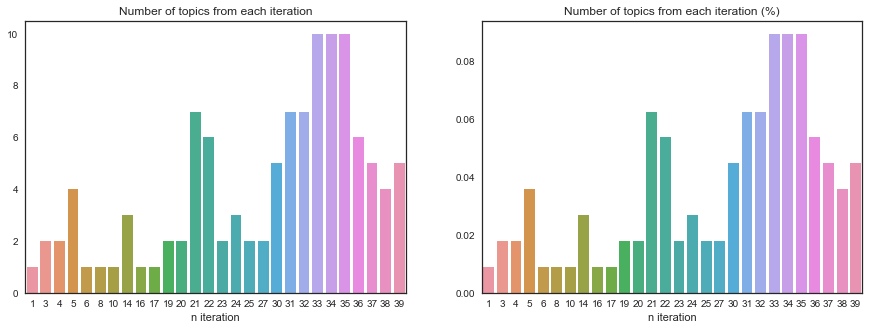

In [27]:
%matplotlib inline
plot_convex_hull_topics_iterations_distribution(phi_convex_hull_2)

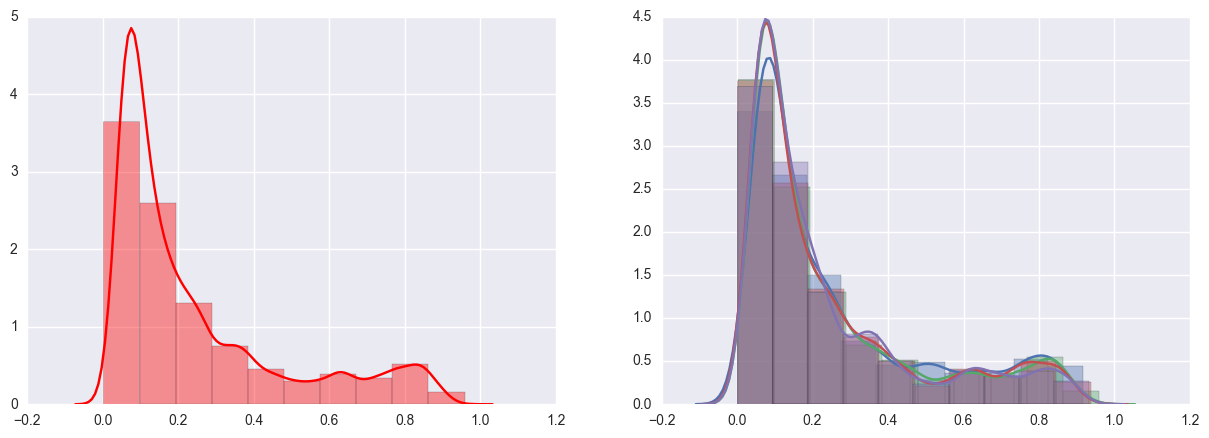

In [9]:
%matplotlib inline
plot_convex_hull_topics_iterations_distribution(phi_convex_hull_2)

plot_opt_res_fun('iterations_filtering_info_2')

In [10]:
OPT_FUN_THRESHOLD = 0.6
phi_convex_hull_3, iterations_info_3, iterations_filtering_info_3 = build_convex_hull_delayed_filtering(create_model_fn_3, get_topics_to_remove_by_opt_fun_and_distance, 
                                                     phi_original.index,
                                                     init_convex_hull=[], start_iteration=0,
                                                     max_iteration=150, filtering_iteration=150)
plot_convex_hull_topics_iterations_distribution(phi_convex_hull_3)
save_pickle_file(phi_convex_hull_3, 'phi_convex_hull_3')

[2017-02-07 22:38:35.591000] ********** iteration = 1 / 150
name = model_20_m3_iter_0, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25
ss_theta_regularizer, tau = -5
decorrelator_phi_regularizer, tau = 300
ss_phi_regularizer, tau = -20

[2017-02-07 22:38:43.721000] current convex_hull shape = (2216, 20)
[2017-02-07 22:38:43.721000] ********** iteration = 2 / 150
name = model_20_m3_iter_1, n_topics = 20, n_doc_passes = 5, seed_value = 101, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25
ss_theta_regularizer, tau = -5
decorrelator_phi_regularizer, tau = 300
ss_phi_regularizer, tau = -20

[2017-02-07 22:38:52.056000] current convex_hull shape = (2216, 40)
[2017-02-07 22:38:52.056000] ********** iteration = 3 / 150
name = model_20_m3_iter_2, n_topics = 20, n_doc_passes = 5, seed_value = 102, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25
ss_theta_regularizer, tau = -5
decorrelator_phi_regularizer, tau = 300
ss_p

[(1, 1, 0.017857142857142856), (3, 2, 0.03571428571428571), (133, 1, 0.017857142857142856), (7, 1, 0.017857142857142856), (136, 1, 0.017857142857142856), (137, 2, 0.03571428571428571), (10, 1, 0.017857142857142856), (11, 1, 0.017857142857142856), (140, 1, 0.017857142857142856), (13, 1, 0.017857142857142856), (14, 1, 0.017857142857142856), (141, 1, 0.017857142857142856), (145, 1, 0.017857142857142856), (146, 1, 0.017857142857142856), (131, 1, 0.017857142857142856), (22, 1, 0.017857142857142856), (26, 1, 0.017857142857142856), (27, 2, 0.03571428571428571), (33, 1, 0.017857142857142856), (36, 1, 0.017857142857142856), (37, 2, 0.03571428571428571), (40, 1, 0.017857142857142856), (43, 1, 0.017857142857142856), (47, 1, 0.017857142857142856), (50, 2, 0.03571428571428571), (56, 1, 0.017857142857142856), (60, 1, 0.017857142857142856), (138, 1, 0.017857142857142856), (62, 2, 0.03571428571428571), (65, 1, 0.017857142857142856), (139, 1, 0.017857142857142856), (71, 1, 0.017857142857142856), (129, 

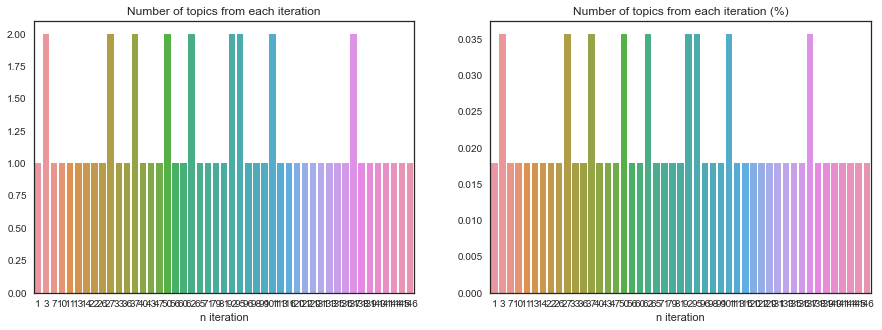

In [28]:
plot_convex_hull_topics_iterations_distribution(phi_convex_hull_3)

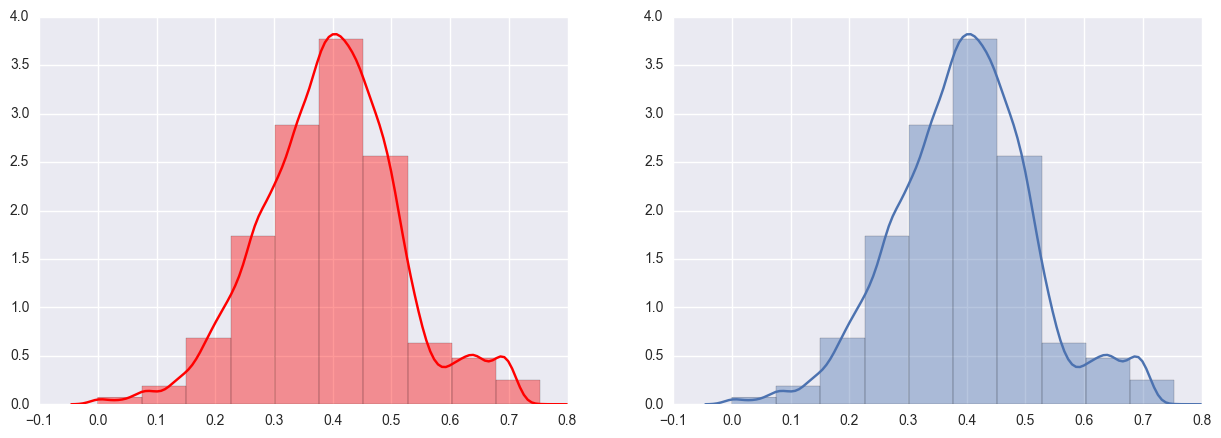

In [10]:
plot_opt_res_fun('iterations_filtering_info_3')

In [15]:
OPT_FUN_THRESHOLD = 0.6
phi_convex_hull_4, iterations_info_4, iterations_filtering_info_4 = build_convex_hull_delayed_filtering(create_model_fn_4, get_topics_to_remove_by_opt_fun_and_distance, 
                                                     phi_original.index,
                                                     init_convex_hull=[], start_iteration=0,
                                                     max_iteration=40, filtering_iteration=10)
plot_convex_hull_topics_iterations_distribution(phi_convex_hull_4)
save_pickle_file(phi_convex_hull_4, 'phi_convex_hull_4')

[2017-02-08 13:28:43.512000] ********** iteration = 1 / 40
name = model_20_m4_iter_0, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25
ss_theta_regularizer, tau = -0.5
decorrelator_phi_regularizer, tau = 10
ss_phi_regularizer, tau = -2

[2017-02-08 13:29:03.381000] current convex_hull shape = (2216, 100)
[2017-02-08 13:29:03.381000] ********** iteration = 2 / 40
name = model_20_m4_iter_1, n_topics = 100, n_doc_passes = 5, seed_value = 101, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25
ss_theta_regularizer, tau = -0.5
decorrelator_phi_regularizer, tau = 10
ss_phi_regularizer, tau = -2

[2017-02-08 13:29:24.146000] current convex_hull shape = (2216, 200)
[2017-02-08 13:29:24.146000] ********** iteration = 3 / 40
name = model_20_m4_iter_2, n_topics = 100, n_doc_passes = 5, seed_value = 102, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25
ss_theta_regularizer, tau = -0.5
decorrelator_phi_regularizer, tau = 10
s

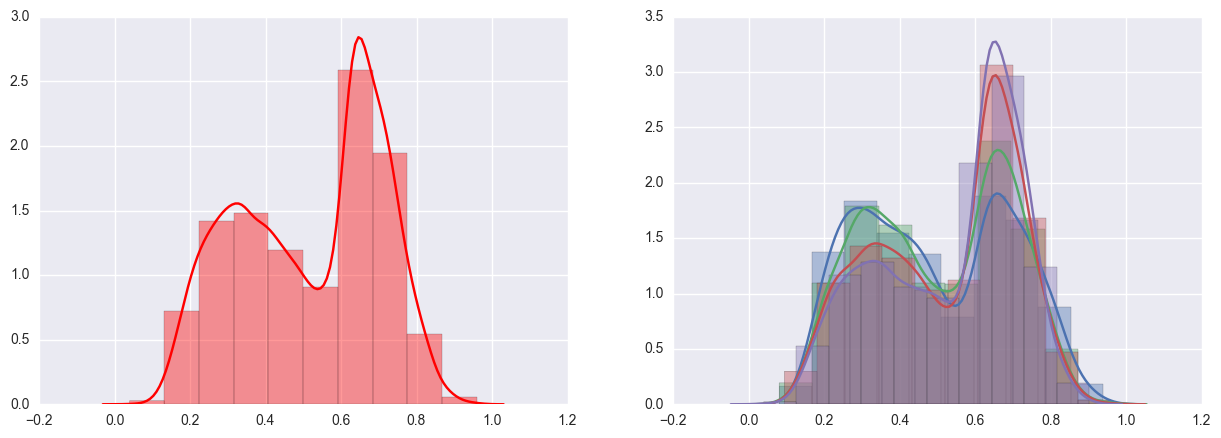

In [11]:
plot_opt_res_fun('iterations_filtering_info_4')

# build_convex_hull_with_filtering

In [11]:
OPT_FUN_THRESHOLD = 0.6
phi_convex_hull_21, iterations_info_21, iterations_filtering_info_21 = build_convex_hull_with_filtering(create_model_fn_1, get_topics_to_remove_by_opt_fun_and_distance, 
                                                     phi_original.index,
                                                     init_convex_hull=[], start_iteration=0,
                                                     max_iteration=150)
save_pickle_file(phi_convex_hull_21, 'phi_convex_hull_21')
plot_convex_hull_topics_iterations_distribution(phi_convex_hull_21)
plot_convex_hull_columns_change(iterations_info_21)

[2017-02-08 01:27:11.653000] ********** iteration = 1 / 150
name = model_20_m1_iter_0, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25

[2017-02-08 01:27:21.827000] filtering iteration = 1 / 15
[2017-02-08 01:27:24.460000] 0 topics to remove, 0 not_removed_topics_count because close topics, current convex_hull shape = (2216, 20)
[2017-02-08 01:27:24.460000] filtering iteration = 2 / 15
[2017-02-08 01:27:26.712000] 0 topics to remove, 0 not_removed_topics_count because close topics, current convex_hull shape = (2216, 20)
[2017-02-08 01:27:26.712000] topics to remove not increasing, breaking the for loop
[2017-02-08 01:27:26.712000] current convex_hull shape = (2216, 20)
[2017-02-08 01:27:26.712000] ********** iteration = 2 / 150
name = model_20_m1_iter_1, n_topics = 20, n_doc_passes = 5, seed_value = 101, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25

[2017-02-08 01:27:37.349000] filtering iteration = 1 / 15
[2017-02

C:\Users\jluka\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


[(149, 8, 0.2857142857142857), (136, 1, 0.03571428571428571), (138, 1, 0.03571428571428571), (139, 1, 0.03571428571428571), (110, 1, 0.03571428571428571), (143, 2, 0.07142857142857142), (145, 2, 0.07142857142857142), (146, 3, 0.10714285714285714), (115, 1, 0.03571428571428571), (148, 3, 0.10714285714285714), (142, 1, 0.03571428571428571), (86, 1, 0.03571428571428571), (89, 1, 0.03571428571428571), (25, 1, 0.03571428571428571), (127, 1, 0.03571428571428571)]


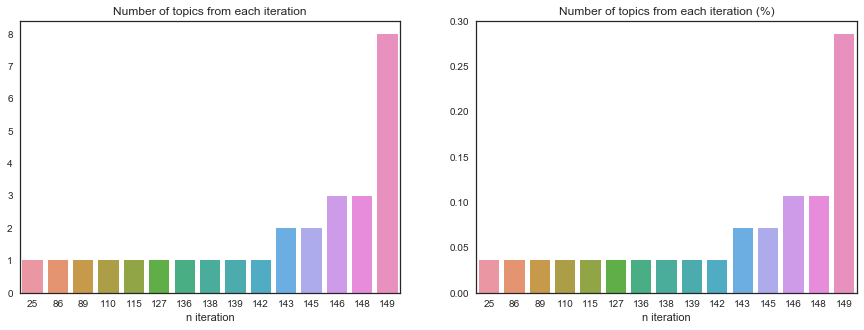

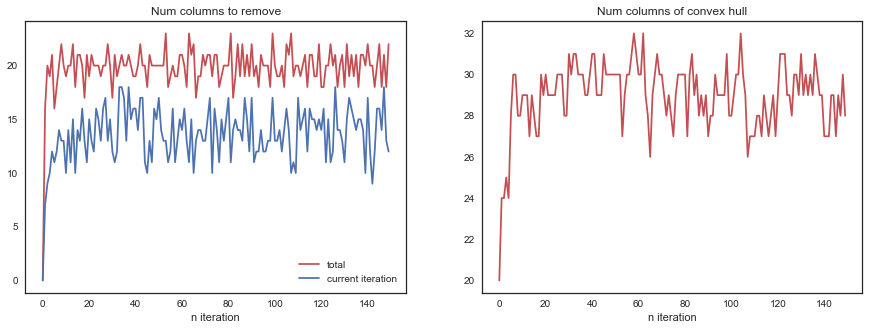

In [29]:
plot_convex_hull_topics_iterations_distribution(phi_convex_hull_21)
plot_convex_hull_columns_change(iterations_info_21)

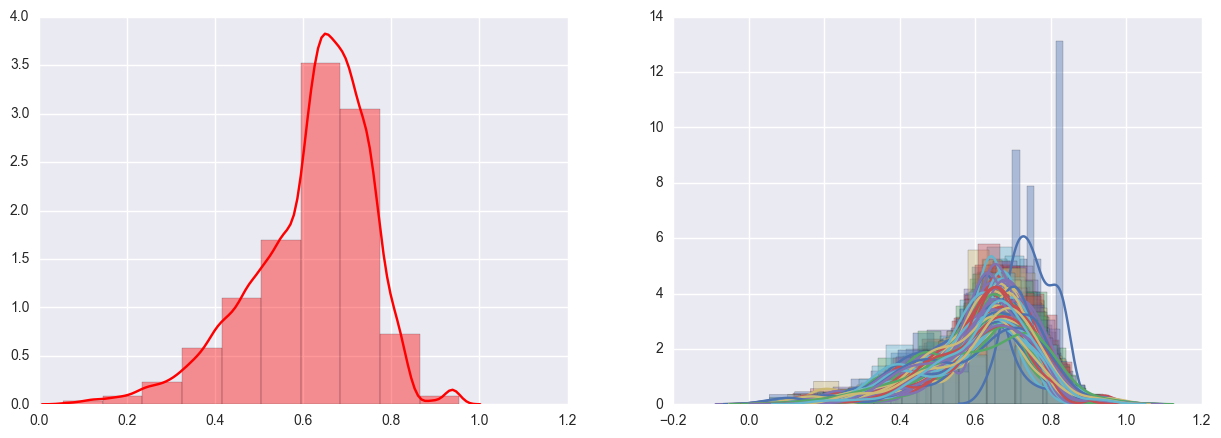

In [12]:
plot_opt_res_fun_filtering('iterations_info_21')

[2017-02-08 17:48:56.908000] ********** iteration = 1 / 50
name = model_20_m1_iter_0, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25

[2017-02-08 17:49:07.159000] filtering iteration = 1 / 15
[2017-02-08 17:49:08.980000] 0 topics to remove, 0 not_removed_topics_count because close topics, current convex_hull shape = (2216, 20)
[2017-02-08 17:49:08.980000] filtering iteration = 2 / 15
[2017-02-08 17:49:11.792000] 0 topics to remove, 0 not_removed_topics_count because close topics, current convex_hull shape = (2216, 20)
[2017-02-08 17:49:11.792000] topics to remove not increasing, breaking the for loop
[2017-02-08 17:49:11.792000] current convex_hull shape = (2216, 20)
[2017-02-08 17:49:11.792000] ********** iteration = 2 / 50
name = model_20_m1_iter_1, n_topics = 20, n_doc_passes = 5, seed_value = 101, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25

[2017-02-08 17:49:24.447000] filtering iteration = 1 / 15
[2017-02-0

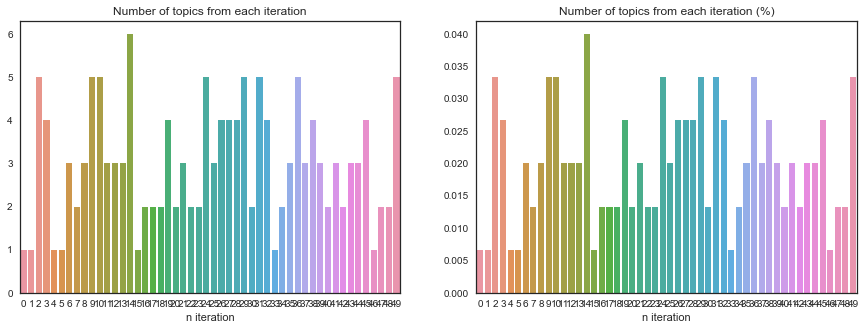

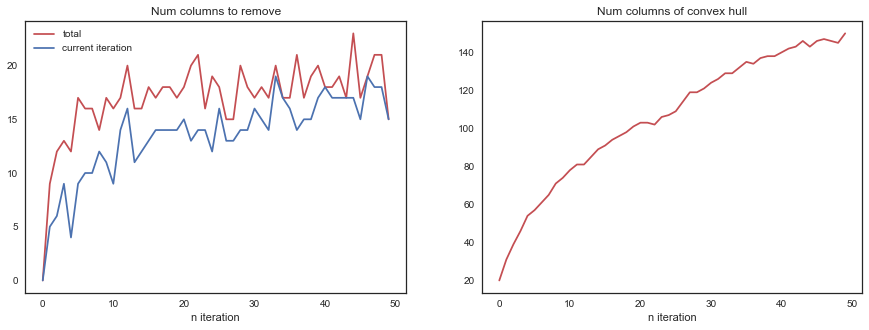

In [37]:
OPT_FUN_THRESHOLD = 0.4
phi_convex_hull_31, iterations_info_31, iterations_filtering_info_31 = build_convex_hull_with_filtering(create_model_fn_1, get_topics_to_remove_by_opt_fun_and_distance, 
                                                     phi_original.index,
                                                     init_convex_hull=[], start_iteration=0,
                                                     max_iteration=50)
save_pickle_file(phi_convex_hull_31, 'phi_convex_hull_31')
plot_convex_hull_topics_iterations_distribution(phi_convex_hull_31)
plot_convex_hull_columns_change(iterations_info_31)

In [40]:
save_pickle_file(iterations_info_31, 'iterations_info_31')
save_pickle_file(iterations_filtering_info_31, 'iterations_filtering_info_31')

C:\Users\Sheldon\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:5991: RuntimeWarning: invalid value encountered in true_divide
  m = (m.astype(float) / db) / m.sum()
C:\Users\Sheldon\Anaconda2\lib\site-packages\numpy\core\_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
C:\Users\Sheldon\Anaconda2\lib\site-packages\numpy\core\_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Sheldon\Anaconda2\lib\site-packages\numpy\core\_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Sheldon\Anaconda2\lib\site-packages\statsmodels\nonparametric\bandwidths.py:20: RuntimeWarning: invalid value encountered in minimum
  return np.minimum(np.std(X, axis=0, ddof=1), IQR)


ZeroDivisionError: 0.0 cannot be raised to a negative power

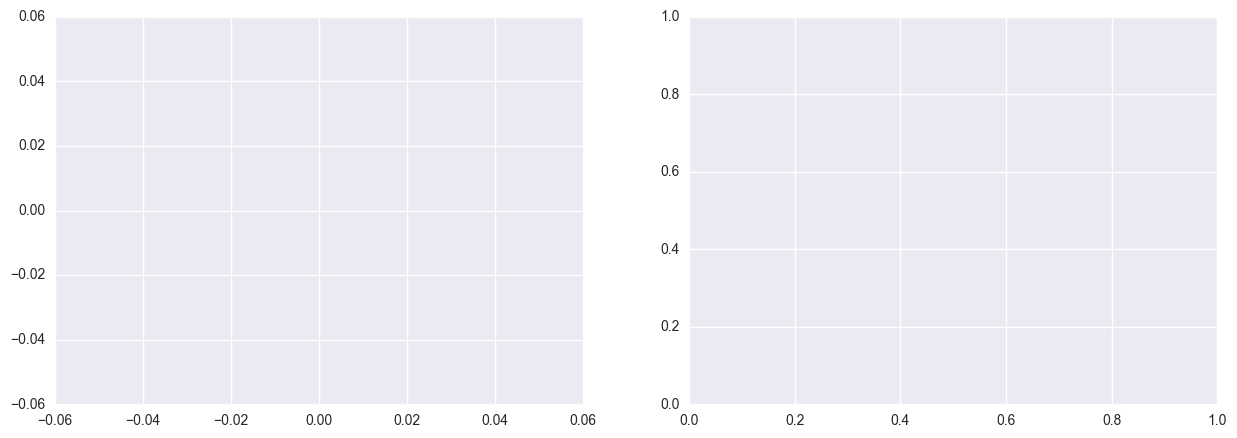

In [14]:
plot_opt_res_fun_filtering('iterations_filtering_info_31')

[2017-02-10 14:42:02.186000] ********** iteration = 1 / 40
name = model_20_m1_iter_0, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25

[2017-02-10 14:42:30.546000] filtering iteration = 1 / 15
[2017-02-10 14:42:33.325000] 0 topics to remove, 0 not_removed_topics_count because close topics, current convex_hull shape = (2216, 20)
[2017-02-10 14:42:33.325000] filtering iteration = 2 / 15
[2017-02-10 14:42:36.647000] 0 topics to remove, 0 not_removed_topics_count because close topics, current convex_hull shape = (2216, 20)
[2017-02-10 14:42:36.647000] topics to remove not increasing, breaking the for loop
[2017-02-10 14:42:36.647000] current convex_hull shape = (2216, 20)
[2017-02-10 14:42:36.647000] ********** iteration = 2 / 40
name = model_20_m1_iter_1, n_topics = 20, n_doc_passes = 5, seed_value = 101, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25

[2017-02-10 14:43:02.194000] filtering iteration = 1 / 15
[2017-02-1

C:\Users\Sheldon\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


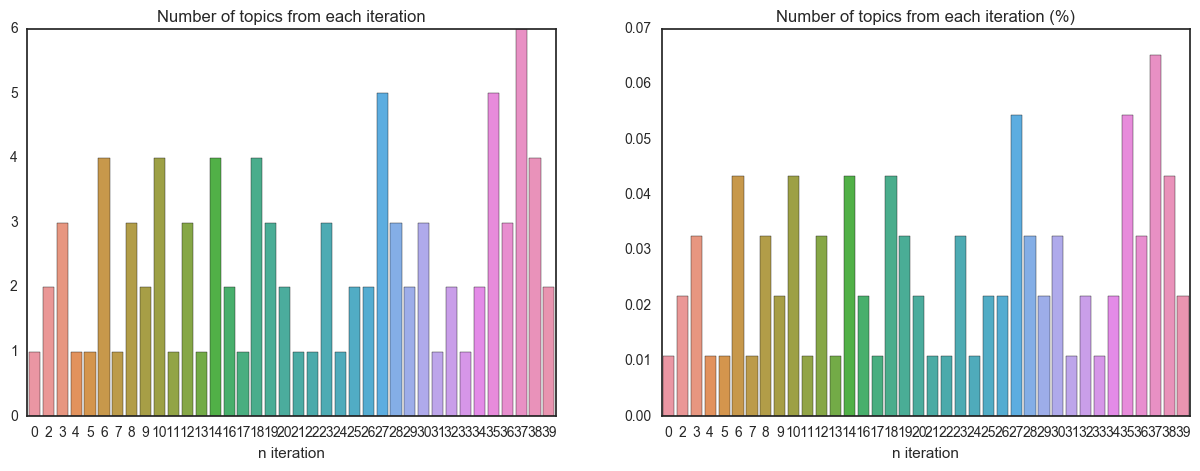

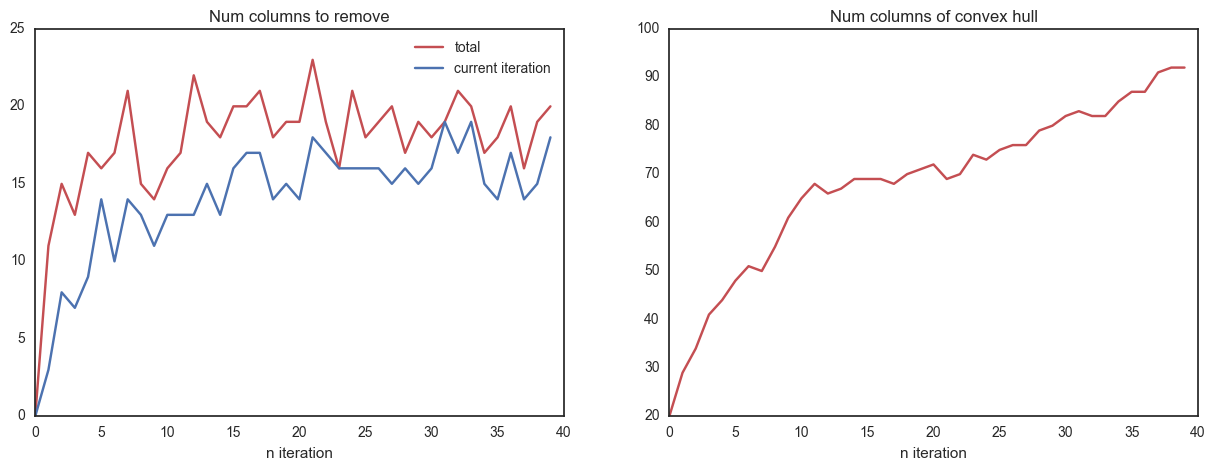

In [19]:
OPT_FUN_THRESHOLD = 0.45
phi_convex_hull_41, iterations_info_41, iterations_filtering_info_41 = build_convex_hull_with_filtering(create_model_fn_1, get_topics_to_remove_by_opt_fun_and_distance, 
                                                     phi_original.index,
                                                     init_convex_hull=[], start_iteration=0,
                                                     max_iteration=40)
save_pickle_file(phi_convex_hull_41, 'phi_convex_hull_41')
save_pickle_file(iterations_info_41, 'iterations_info_41')
plot_convex_hull_topics_iterations_distribution(phi_convex_hull_41)
plot_convex_hull_columns_change(iterations_info_41)

In [12]:
OPT_FUN_THRESHOLD = 0.6
phi_convex_hull_22, iterations_info_22, iterations_filtering_info_22 = build_convex_hull_with_filtering(create_model_fn_2, get_topics_to_remove_by_opt_fun_and_distance, 
                                                     phi_original.index,
                                                     init_convex_hull=[], start_iteration=0,
                                                     max_iteration=50)
plot_convex_hull_topics_iterations_distribution(phi_convex_hull_22)
plot_convex_hull_columns_change(iterations_info_22)
save_pickle_file(phi_convex_hull_22, 'phi_convex_hull_22')

[2017-02-08 02:59:13.414000] ********** iteration = 1 / 50
name = model_100_m2_iter_0, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25

[2017-02-08 02:59:41.118000] filtering iteration = 1 / 15
[2017-02-08 02:59:51.245000] 4 topics to remove, 7 not_removed_topics_count because close topics, current convex_hull shape = (2216, 96)
[2017-02-08 02:59:51.245000] filtering iteration = 2 / 15
[2017-02-08 03:00:01.180000] 1 topics to remove, 4 not_removed_topics_count because close topics, current convex_hull shape = (2216, 95)
[2017-02-08 03:00:01.181000] filtering iteration = 3 / 15
[2017-02-08 03:00:10.783000] 1 topics to remove, 2 not_removed_topics_count because close topics, current convex_hull shape = (2216, 94)
[2017-02-08 03:00:10.783000] filtering iteration = 4 / 15
[2017-02-08 03:00:20.853000] 1 topics to remove, 0 not_removed_topics_count because close topics, current convex_hull shape = (2216, 93)
[2017-02-08 03:00:20.85

[(35, 1, 0.009009009009009009), (37, 2, 0.018018018018018018), (38, 1, 0.009009009009009009), (39, 1, 0.009009009009009009), (40, 3, 0.02702702702702703), (41, 4, 0.036036036036036036), (42, 1, 0.009009009009009009), (44, 6, 0.05405405405405406), (45, 9, 0.08108108108108109), (46, 11, 0.0990990990990991), (47, 9, 0.08108108108108109), (48, 20, 0.18018018018018017), (49, 40, 0.36036036036036034), (21, 3, 0.02702702702702703)]


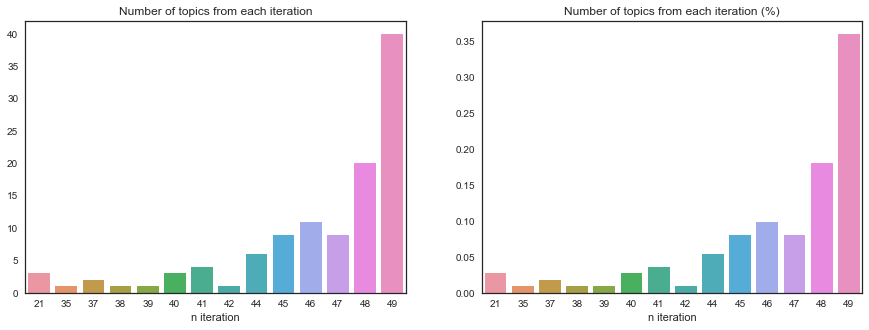

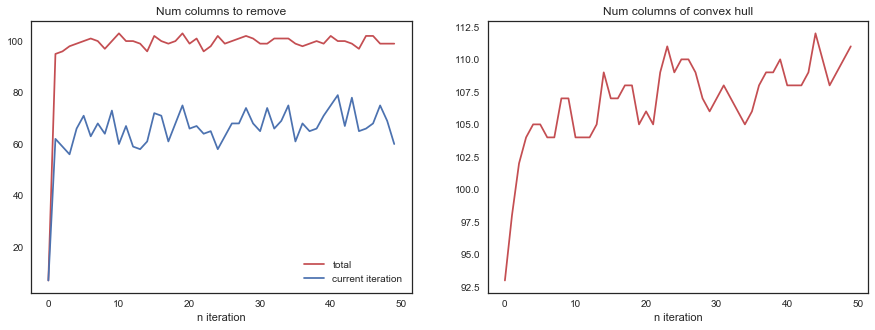

In [30]:
plot_convex_hull_topics_iterations_distribution(phi_convex_hull_22)
plot_convex_hull_columns_change(iterations_info_22)

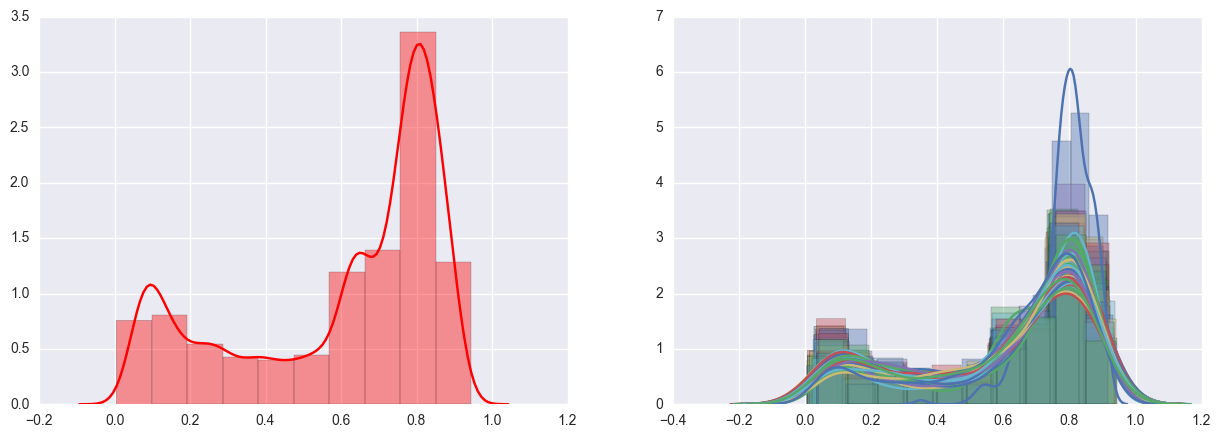

In [15]:
plot_opt_res_fun_filtering('iterations_info_22')

In [13]:
OPT_FUN_THRESHOLD = 0.6
phi_convex_hull_23, iterations_info_23, iterations_filtering_info_23 = build_convex_hull_with_filtering(create_model_fn_3, get_topics_to_remove_by_opt_fun_and_distance, 
                                                     phi_original.index,
                                                     init_convex_hull=[], start_iteration=0,
                                                     max_iteration=150)
plot_convex_hull_topics_iterations_distribution(phi_convex_hull_23)
plot_convex_hull_columns_change(iterations_info_23)
save_pickle_file(phi_convex_hull_23, 'phi_convex_hull_23')

[2017-02-08 04:59:56.236000] ********** iteration = 1 / 150
name = model_20_m3_iter_0, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25
ss_theta_regularizer, tau = -5
decorrelator_phi_regularizer, tau = 300
ss_phi_regularizer, tau = -20

[2017-02-08 05:00:04.974000] filtering iteration = 1 / 15
[2017-02-08 05:00:07.516000] 0 topics to remove, 0 not_removed_topics_count because close topics, current convex_hull shape = (2216, 20)
[2017-02-08 05:00:07.516000] filtering iteration = 2 / 15
[2017-02-08 05:00:09.919000] 0 topics to remove, 0 not_removed_topics_count because close topics, current convex_hull shape = (2216, 20)
[2017-02-08 05:00:09.919000] topics to remove not increasing, breaking the for loop
[2017-02-08 05:00:09.919000] current convex_hull shape = (2216, 20)
[2017-02-08 05:00:09.919000] ********** iteration = 2 / 150
name = model_20_m3_iter_1, n_topics = 20, n_doc_passes = 5, seed_value = 101, n_iterations = 20, n_to

[(131, 1, 0.017543859649122806), (133, 2, 0.03508771929824561), (135, 1, 0.017543859649122806), (136, 1, 0.017543859649122806), (137, 1, 0.017543859649122806), (138, 2, 0.03508771929824561), (11, 1, 0.017543859649122806), (140, 1, 0.017543859649122806), (141, 3, 0.05263157894736842), (142, 1, 0.017543859649122806), (143, 3, 0.05263157894736842), (144, 2, 0.03508771929824561), (145, 2, 0.03508771929824561), (146, 2, 0.03508771929824561), (147, 2, 0.03508771929824561), (148, 1, 0.017543859649122806), (149, 1, 0.017543859649122806), (22, 1, 0.017543859649122806), (26, 1, 0.017543859649122806), (33, 1, 0.017543859649122806), (34, 1, 0.017543859649122806), (36, 1, 0.017543859649122806), (37, 1, 0.017543859649122806), (40, 1, 0.017543859649122806), (43, 1, 0.017543859649122806), (47, 1, 0.017543859649122806), (51, 2, 0.03508771929824561), (55, 1, 0.017543859649122806), (60, 2, 0.03508771929824561), (69, 2, 0.03508771929824561), (76, 1, 0.017543859649122806), (78, 1, 0.017543859649122806), (8

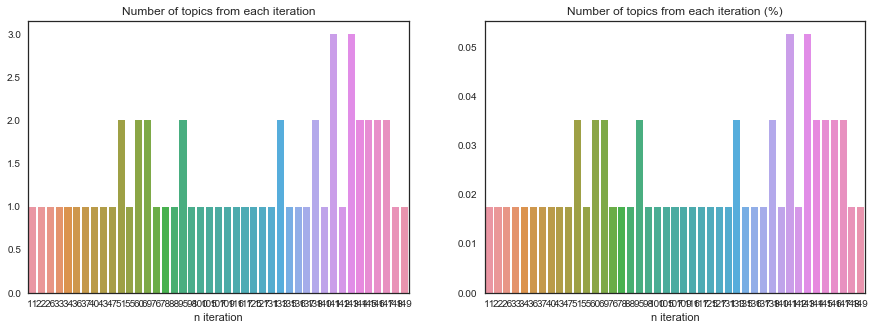

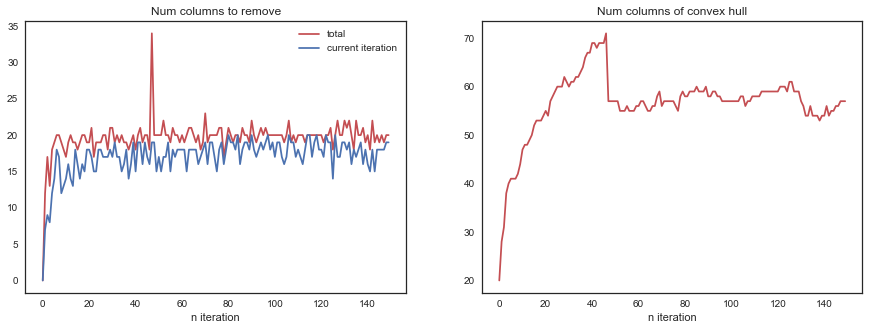

In [31]:
plot_convex_hull_topics_iterations_distribution(phi_convex_hull_23)
plot_convex_hull_columns_change(iterations_info_23)

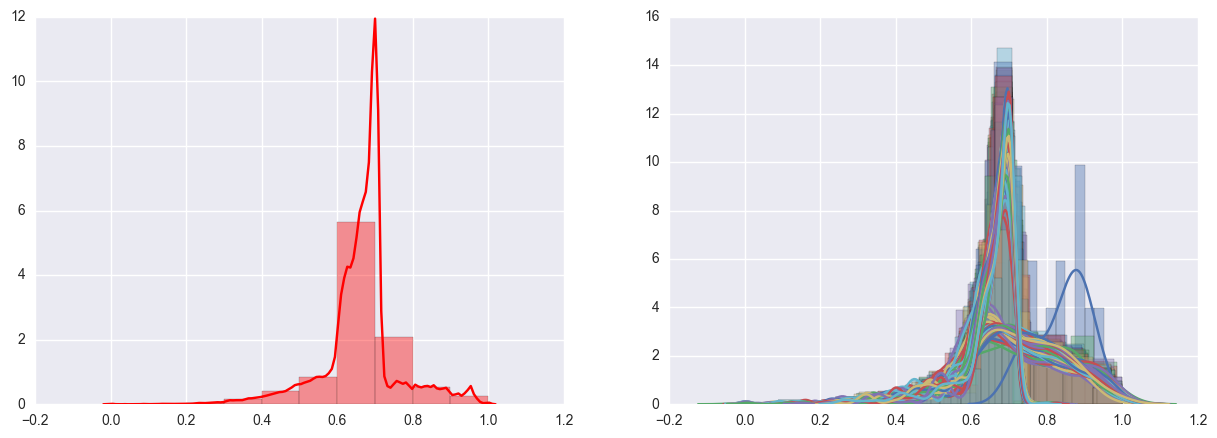

In [16]:
plot_opt_res_fun_filtering('iterations_info_23')

In [14]:
OPT_FUN_THRESHOLD = 0.6
phi_convex_hull_24, iterations_info_24, iterations_filtering_info_24 = build_convex_hull_with_filtering(create_model_fn_4, get_topics_to_remove_by_opt_fun_and_distance, 
                                                     phi_original.index,
                                                     init_convex_hull=[], start_iteration=0,
                                                     max_iteration=50)
plot_convex_hull_topics_iterations_distribution(phi_convex_hull_24)
plot_convex_hull_columns_change(iterations_info_24)
save_pickle_file(phi_convex_hull_24, 'phi_convex_hull_24')

[2017-02-08 08:25:34.664000] ********** iteration = 1 / 50
name = model_20_m4_iter_0, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25
ss_theta_regularizer, tau = -0.5
decorrelator_phi_regularizer, tau = 10
ss_phi_regularizer, tau = -2

[2017-02-08 08:25:59.505000] filtering iteration = 1 / 15
[2017-02-08 08:26:11.869000] 1 topics to remove, 3 not_removed_topics_count because close topics, current convex_hull shape = (2216, 99)
[2017-02-08 08:26:11.869000] filtering iteration = 2 / 15
[2017-02-08 08:26:23.368000] 1 topics to remove, 1 not_removed_topics_count because close topics, current convex_hull shape = (2216, 98)
[2017-02-08 08:26:23.368000] filtering iteration = 3 / 15
[2017-02-08 08:26:34.555000] 0 topics to remove, 0 not_removed_topics_count because close topics, current convex_hull shape = (2216, 98)
[2017-02-08 08:26:34.556000] filtering iteration = 4 / 15
[2017-02-08 08:26:46.282000] 0 topics to remove, 0 not_remov

[(0, 15, 0.027624309392265192), (1, 7, 0.01289134438305709), (2, 6, 0.011049723756906077), (3, 12, 0.022099447513812154), (4, 11, 0.020257826887661142), (5, 8, 0.014732965009208104), (6, 16, 0.029465930018416207), (7, 8, 0.014732965009208104), (8, 10, 0.01841620626151013), (9, 10, 0.01841620626151013), (10, 8, 0.014732965009208104), (11, 10, 0.01841620626151013), (12, 13, 0.02394106813996317), (13, 5, 0.009208103130755065), (14, 12, 0.022099447513812154), (15, 6, 0.011049723756906077), (16, 9, 0.016574585635359115), (17, 9, 0.016574585635359115), (18, 9, 0.016574585635359115), (19, 9, 0.016574585635359115), (20, 9, 0.016574585635359115), (21, 6, 0.011049723756906077), (22, 10, 0.01841620626151013), (23, 8, 0.014732965009208104), (24, 9, 0.016574585635359115), (25, 10, 0.01841620626151013), (26, 12, 0.022099447513812154), (27, 12, 0.022099447513812154), (28, 17, 0.03130755064456722), (29, 7, 0.01289134438305709), (30, 11, 0.020257826887661142), (31, 14, 0.02578268876611418), (32, 10, 0.

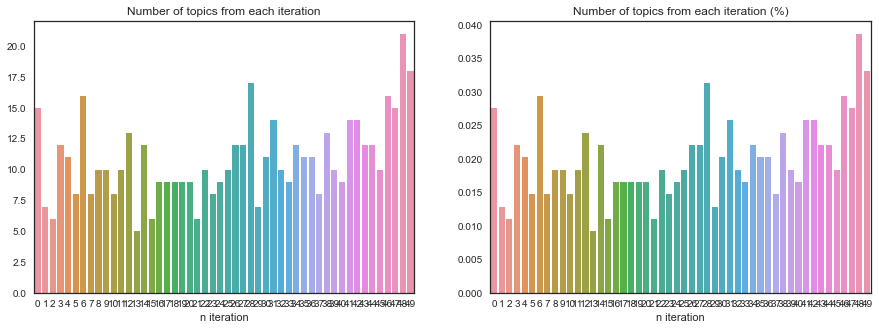

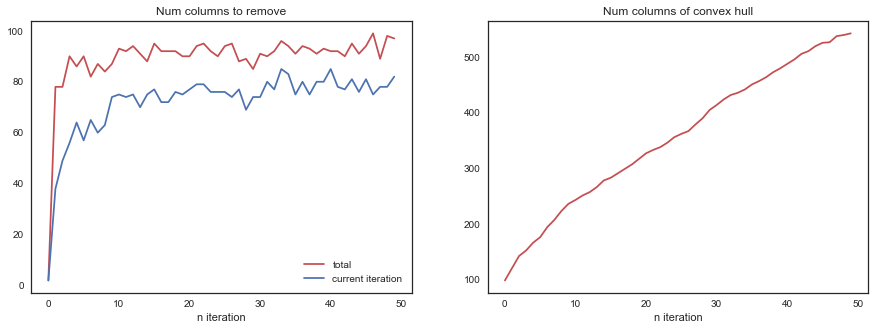

In [32]:
plot_convex_hull_topics_iterations_distribution(phi_convex_hull_24)
plot_convex_hull_columns_change(iterations_info_24)

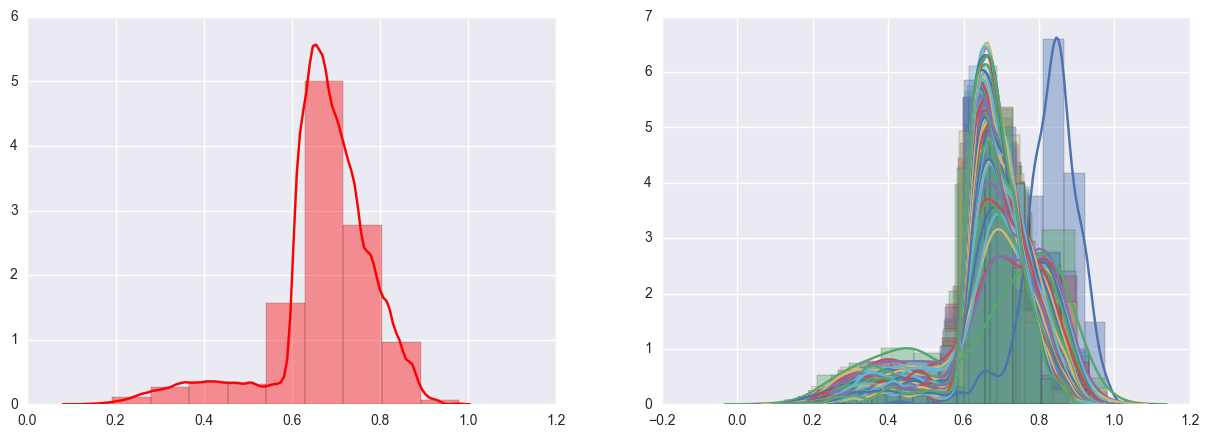

In [17]:
plot_opt_res_fun_filtering('iterations_info_24')

[2017-02-08 17:37:20.110000] filtering iteration = 1 / 3
[2017-02-08 17:38:21.583000] 0 topics to remove, 0 not_removed_topics_count because close topics, current convex_hull shape = (2216, 543)
[2017-02-08 17:38:21.584000] filtering iteration = 2 / 3
[2017-02-08 17:39:22.696000] 0 topics to remove, 0 not_removed_topics_count because close topics, current convex_hull shape = (2216, 543)
[2017-02-08 17:39:22.696000] topics to remove not increasing, breaking the for loop
[(0, 15, 0.027624309392265192), (1, 7, 0.01289134438305709), (2, 6, 0.011049723756906077), (3, 12, 0.022099447513812154), (4, 11, 0.020257826887661142), (5, 8, 0.014732965009208104), (6, 16, 0.029465930018416207), (7, 8, 0.014732965009208104), (8, 10, 0.01841620626151013), (9, 10, 0.01841620626151013), (10, 8, 0.014732965009208104), (11, 10, 0.01841620626151013), (12, 13, 0.02394106813996317), (13, 5, 0.009208103130755065), (14, 12, 0.022099447513812154), (15, 6, 0.011049723756906077), (16, 9, 0.016574585635359115), (17,

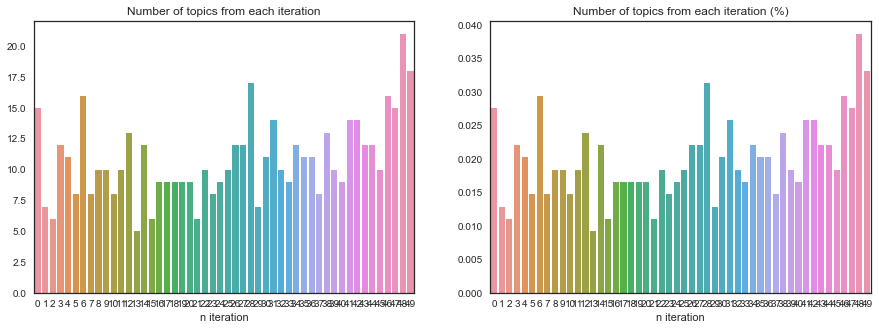

In [35]:
OPT_FUN_THRESHOLD = 0.6
phi_convex_hull_24_filteres, iterations_info_filter_24_filtered = filter_convex_hull(phi_convex_hull_24, 
    get_topics_to_remove_by_opt_fun_and_distance, max_iteration=3)
plot_convex_hull_topics_iterations_distribution(phi_convex_hull_24_filteres)
# plot_convex_hull_columns_change(iterations_info_filter_24_filtered)

[2017-02-08 17:42:17.014000] filtering iteration = 1 / 25
[2017-02-08 17:43:20.811000] 69 topics to remove, 267 not_removed_topics_count because close topics, current convex_hull shape = (2216, 474)
[2017-02-08 17:43:20.812000] filtering iteration = 2 / 25
[2017-02-08 17:44:19.669000] 60 topics to remove, 174 not_removed_topics_count because close topics, current convex_hull shape = (2216, 414)
[2017-02-08 17:44:19.669000] filtering iteration = 3 / 25
[2017-02-08 17:45:03.733000] 43 topics to remove, 106 not_removed_topics_count because close topics, current convex_hull shape = (2216, 371)
[2017-02-08 17:45:03.733000] filtering iteration = 4 / 25
[2017-02-08 17:45:42.066000] 29 topics to remove, 53 not_removed_topics_count because close topics, current convex_hull shape = (2216, 342)
[2017-02-08 17:45:42.066000] filtering iteration = 5 / 25
[2017-02-08 17:46:18.811000] 21 topics to remove, 22 not_removed_topics_count because close topics, current convex_hull shape = (2216, 321)
[2017-0

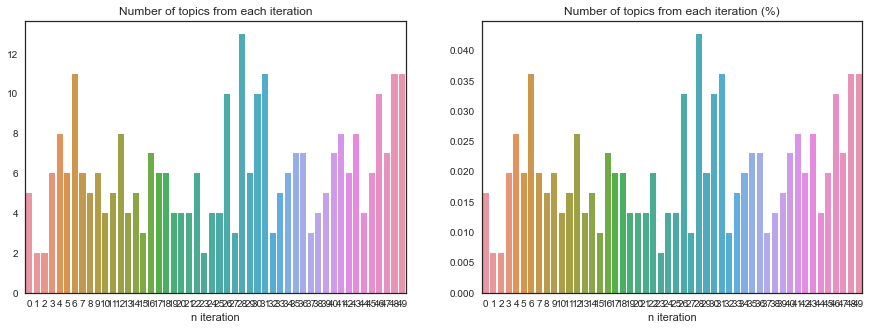

In [36]:
OPT_FUN_THRESHOLD = 0.7
phi_convex_hull_24_filtered, iterations_info_filter_24_filtered = filter_convex_hull(phi_convex_hull_24, 
    get_topics_to_remove_by_opt_fun_and_distance, max_iteration=25)
plot_convex_hull_topics_iterations_distribution(phi_convex_hull_24_filtered)
# plot_convex_hull_columns_change(iterations_info_filter_24_filtered)

In [38]:
save_pickle_file(phi_convex_hull_24_filtered, 'phi_convex_hull_24_filtered_1')
save_pickle_file(iterations_info_filter_24_filtered, 'iterations_info_filter_24_filtered_1')

[2017-02-08 18:49:57.122000] filtering iteration = 1 / 25
[2017-02-08 18:51:05.063000] 90 topics to remove, 424 not_removed_topics_count because close topics, current convex_hull shape = (2216, 453)
[2017-02-08 18:51:05.063000] filtering iteration = 2 / 25
[2017-02-08 18:52:00.153000] 73 topics to remove, 339 not_removed_topics_count because close topics, current convex_hull shape = (2216, 380)
[2017-02-08 18:52:00.153000] filtering iteration = 3 / 25
[2017-02-08 18:52:42.976000] 60 topics to remove, 271 not_removed_topics_count because close topics, current convex_hull shape = (2216, 320)
[2017-02-08 18:52:42.976000] filtering iteration = 4 / 25
[2017-02-08 18:53:18.411000] 48 topics to remove, 204 not_removed_topics_count because close topics, current convex_hull shape = (2216, 272)
[2017-02-08 18:53:18.411000] filtering iteration = 5 / 25
[2017-02-08 18:53:48.247000] 38 topics to remove, 156 not_removed_topics_count because close topics, current convex_hull shape = (2216, 234)
[2017

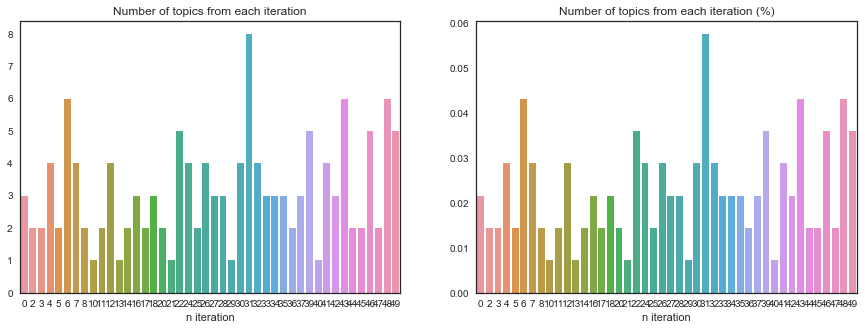

In [39]:
OPT_FUN_THRESHOLD = 0.8
phi_convex_hull_24_filtered, iterations_info_filter_24_filtered = filter_convex_hull(phi_convex_hull_24, 
    get_topics_to_remove_by_opt_fun_and_distance, max_iteration=25)
plot_convex_hull_topics_iterations_distribution(phi_convex_hull_24_filtered)
# plot_convex_hull_columns_change(iterations_info_filter_24_filtered)
save_pickle_file(phi_convex_hull_24_filtered, 'phi_convex_hull_24_filtered_2')
save_pickle_file(iterations_info_filter_24_filtered, 'iterations_info_filter_24_filtered_2')

In [16]:
# save_pickle_file(iterations_filtering_info_1, 'iterations_filtering_info_1') 
save_pickle_file(iterations_filtering_info_2, 'iterations_filtering_info_2') 
save_pickle_file(iterations_filtering_info_3, 'iterations_filtering_info_3') 
save_pickle_file(iterations_filtering_info_4, 'iterations_filtering_info_4') 
save_pickle_file(iterations_filtering_info_21, 'iterations_filtering_info_21') 
save_pickle_file(iterations_filtering_info_22, 'iterations_filtering_info_22')
save_pickle_file(iterations_filtering_info_23, 'iterations_filtering_info_23')
save_pickle_file(iterations_filtering_info_24, 'iterations_filtering_info_24') 

In [17]:
# save_pickle_file(iterations_info_1, 'iterations_info_1') 
save_pickle_file(iterations_info_2, 'iterations_info_2') 
save_pickle_file(iterations_info_3, 'iterations_info_3') 
save_pickle_file(iterations_info_4, 'iterations_info_4') 
save_pickle_file(iterations_info_21, 'iterations_info_21') 
save_pickle_file(iterations_info_22, 'iterations_info_22') 
save_pickle_file(iterations_info_23, 'iterations_info_23') 
save_pickle_file(iterations_info_24, 'iterations_info_24') 

In [33]:
models_file.close()

In [43]:
distances_to_original_2 = calculate_distances(dh.hellinger_dist, phi_convex_hull_2, phi_original)
opt_res_to_original_2 = get_optimization_result(dh.hellinger_dist, None, phi_convex_hull_2, phi_original, distances_to_original_2)
save_pickle_file(opt_res_to_original_2, 'opt_res_to_original_2')

In [ ]:
# построим распределение полученных distances
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
vals = distances_hellinger_model1.values.flatten()
sns.distplot(vals[vals != 0], color='r', ax = ax1, label='model1')
vals = distances_hellinger_model3.values.flatten()
sns.distplot(vals[vals != 0],  color='b', ax = ax1, label='model3')
vals = distances_hellinger_model14.values.flatten()
sns.distplot(vals[vals != 0],  color='g', ax = ax1, label='model14')
ax1.set_title("Inter distances")
ax1.legend()

vals = distances_hellinger_model_1_to_original.values.flatten()
sns.distplot(vals[vals != 0],  color='r', ax = ax2, label='model1')
vals = distances_hellinger_model_3_to_original.values.flatten()
sns.distplot(vals[vals != 0],  color='b', ax = ax2, label='model3')
vals = distances_hellinger_model_14_to_original.values.flatten()
sns.distplot(vals[vals != 0],  color='g', ax = ax2, label='model14')
ax2.set_title("Distances to original")
ax2.legend()

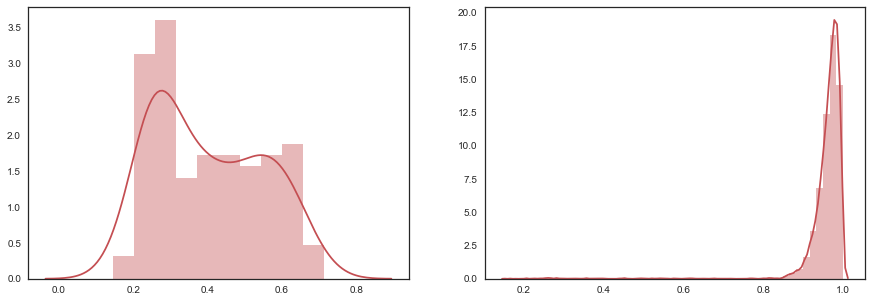

In [44]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
sns.distplot([val.fun for val in opt_res_to_original_2.itervalues()], color='r', bins=10, ax=ax1)

vals = distances_to_original_2.values.flatten()
sns.distplot(vals[vals != 0],  color='r', ax = ax2)

## TO ORIGINAL

In [16]:
def get_distances(phi_original, name):
    phi_convex_hull = load_pickle_file(name)
    distances_to_original = calculate_distances(dh.hellinger_dist, phi_convex_hull, phi_original)
    inter_distances = calculate_distances(dh.hellinger_dist, phi_convex_hull, phi_convex_hull)
    opt_res_to_original = get_optimization_result(dh.hellinger_dist, None, phi_convex_hull, phi_original, distances_to_original)
    save_pickle_file(distances_to_original, 'distances_to_original__' + name)
    save_pickle_file(inter_distances, 'inter_distances__' + name)
    save_pickle_file(opt_res_to_original, 'opt_res_to_original__' + name)
    return phi_convex_hull, distances_to_original, inter_distances, opt_res_to_original
def load_distances(name):
    phi_convex_hull = load_pickle_file(name)
    distances_to_original = load_pickle_file('distances_to_original__' + name)
    inter_distances = load_pickle_file('inter_distances__' + name)
    opt_res_to_original = load_pickle_file('opt_res_to_original__' + name)
    return phi_convex_hull, distances_to_original, inter_distances, opt_res_to_original

In [ ]:
names = ['phi_convex_hull_1', 'phi_convex_hull_2', 'phi_convex_hull_3', 'phi_convex_hull_4',
         'phi_convex_hull_21', 'phi_convex_hull_22', 'phi_convex_hull_23', 'phi_convex_hull_24',
         'phi_convex_hull_31', 'phi_convex_hull_51']
phi_convex_hull_list, distances_to_original_list, inter_distances_list, opt_res_to_original_list = [], [], [], []
for name in names:
    phi_convex_hull, distances_to_original, inter_distances, opt_res_to_original = get_distances(phi_original, name)
    phi_convex_hull_list.append(phi_convex_hull)
    distances_to_original_list.append(distances_to_original)
    inter_distances_list.append(inter_distances)
    opt_res_to_original_list.append(opt_res_to_original)

In [18]:
names = ['phi_convex_hull_1', 'phi_convex_hull_2', 'phi_convex_hull_3', 'phi_convex_hull_4',
         'phi_convex_hull_21', 'phi_convex_hull_22', 'phi_convex_hull_23', 'phi_convex_hull_24',
         'phi_convex_hull_31'] #, 'phi_convex_hull_51']
phi_convex_hull_list, distances_to_original_list, inter_distances_list, opt_res_to_original_list = [], [], [], []
for name in names:
    phi_convex_hull, distances_to_original, inter_distances, opt_res_to_original = load_distances(name)
    phi_convex_hull_list.append(phi_convex_hull)
    distances_to_original_list.append(distances_to_original)
    inter_distances_list.append(inter_distances)
    opt_res_to_original_list.append(opt_res_to_original)

In [19]:
# построим распределение полученных distances
def plot_dists(distances_to_original, inter_distances, opt_res_to_original, name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
    vals = distances_to_original.values.flatten()
    sns.distplot(vals[vals != 0], color='r', ax = ax1, label='Inter distances')
    vals = inter_distances.values.flatten()
    sns.distplot(vals[vals != 0],  color='b', ax = ax1, label='Distances to original')
    ax1.set_title("distances  " + name)
    ax1.legend()
    sns.distplot([val.fun for val in opt_res_to_original.itervalues()], color='r', bins=10, ax=ax2)
    ax2.set_title("opts  " + name)
    ax2.legend()

* phi_convex_hull_1, все opts < 0.4; а по расстоянию довольно таки далеко
* phi_convex_hull_2, средние opts
* phi_convex_hull_3, opts дальше среднего; расстояния двумодальной формы (странно ? проверить)
* phi_convex_hull_4 (original), opt далёкие; расстояния тоже далёкие
* phi_convex_hull_21, phi_convex_hull_22 (модель 1 и 2) по opts близко
* phi_convex_hull_23, opts дальше среднего; расстояния двумодальные
* phi_convex_hull_24 (original), opt далёкие
* phi_convex_hull_31, opt ближе среднего
* phi_convex_hull_22 = перепроверить, что это вторая модель, а не 1ая
* 1ая модель (20 без регуляризаторов) ближе всего
* 2ая модель (100 без рег) средне opt
* 3я модель (20 с рег) далеко
* 4я модель (100 с рег, использовалась для генерации этой выборки) 
* получается, что 
 * <<+>> регуляризаторы удаляют модель
 * модели с 20 темами ближе, чем с 100 (как в оригинале) 

todo: 
* построить модель в которой: 2 темы общие (сглаживать их), остальные 18 разреженные, но по-разному 
* 18 тем с разной гранулярностью, выбрать самую близкую гранулярность  и по ней уже строить convex hull 
* повыводить гранулярности построенных convex hull

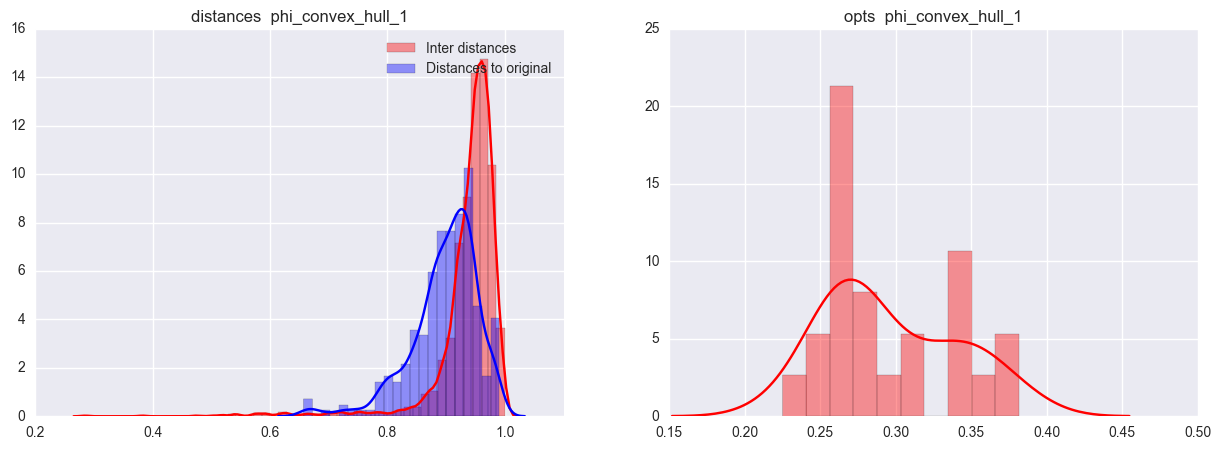

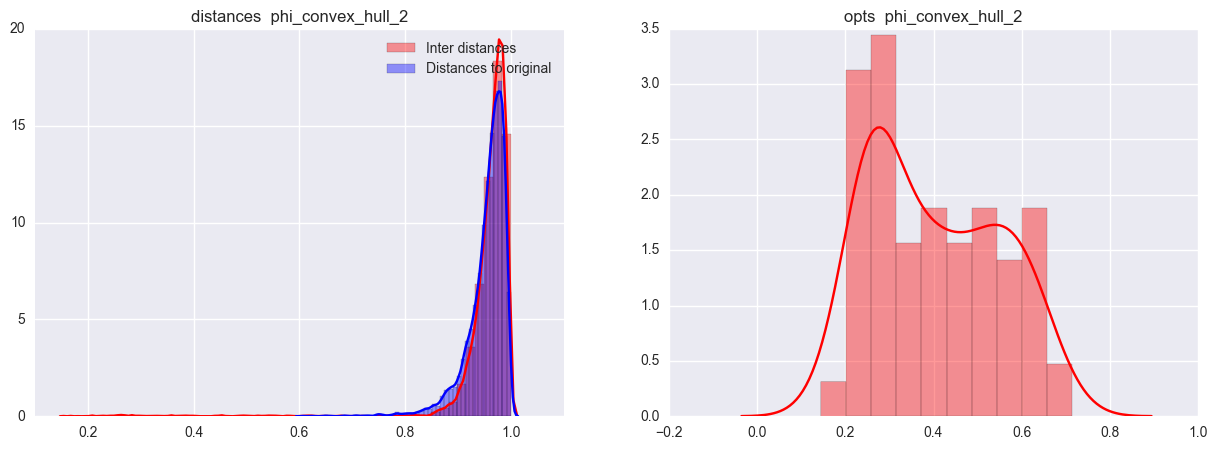

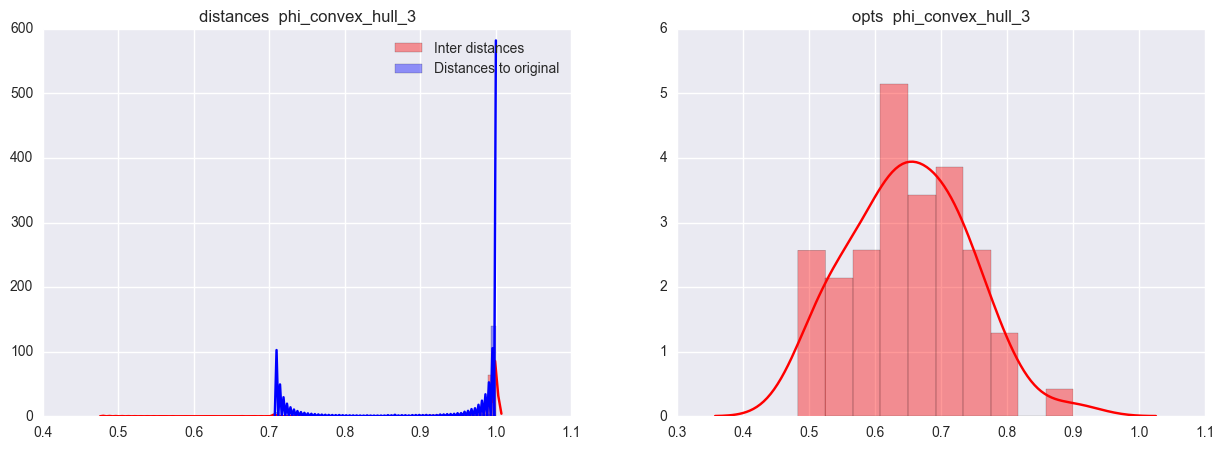

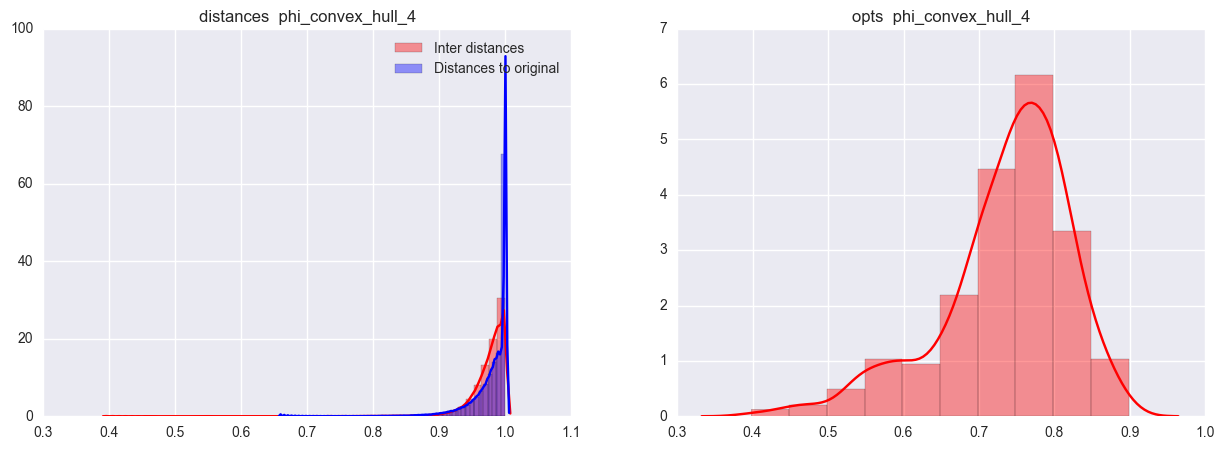

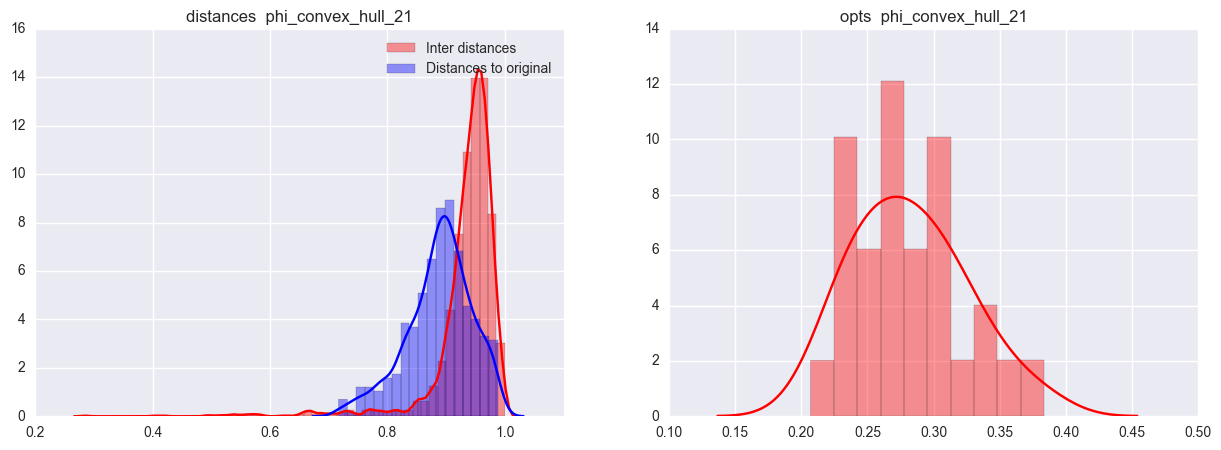

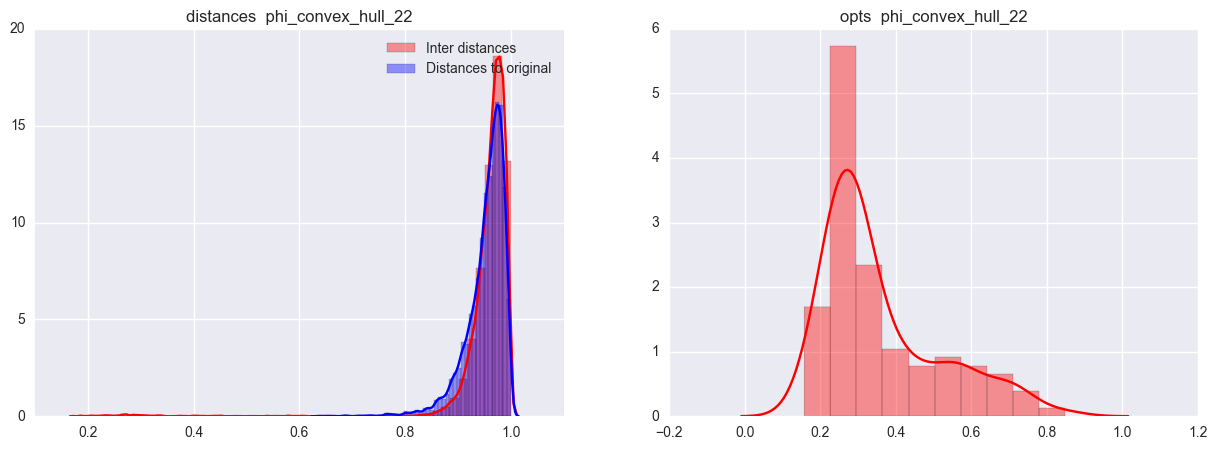

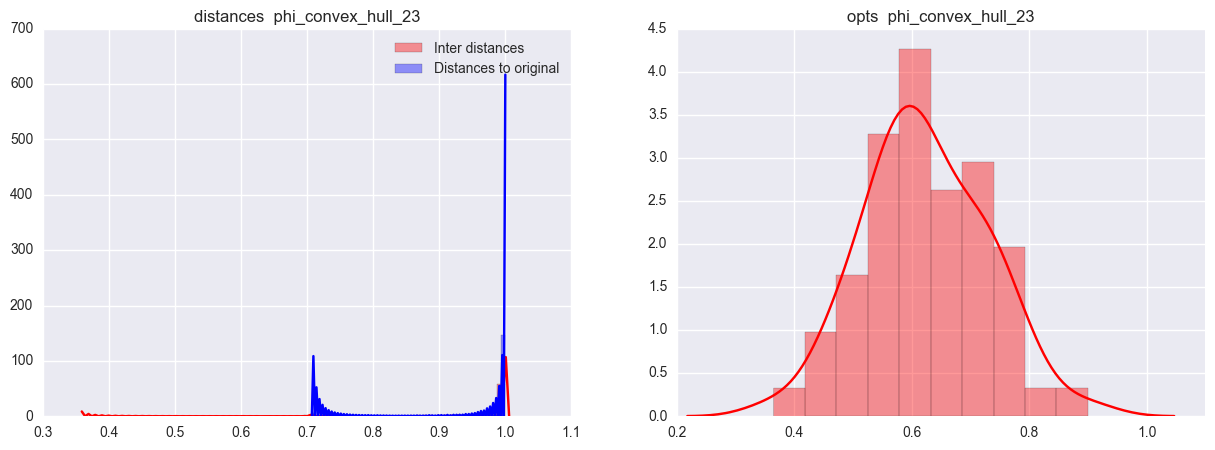

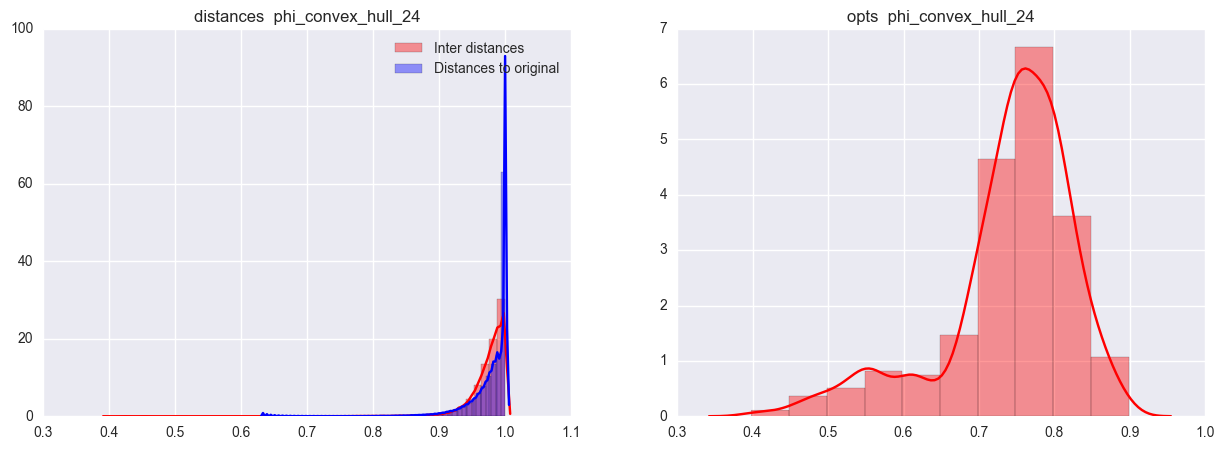

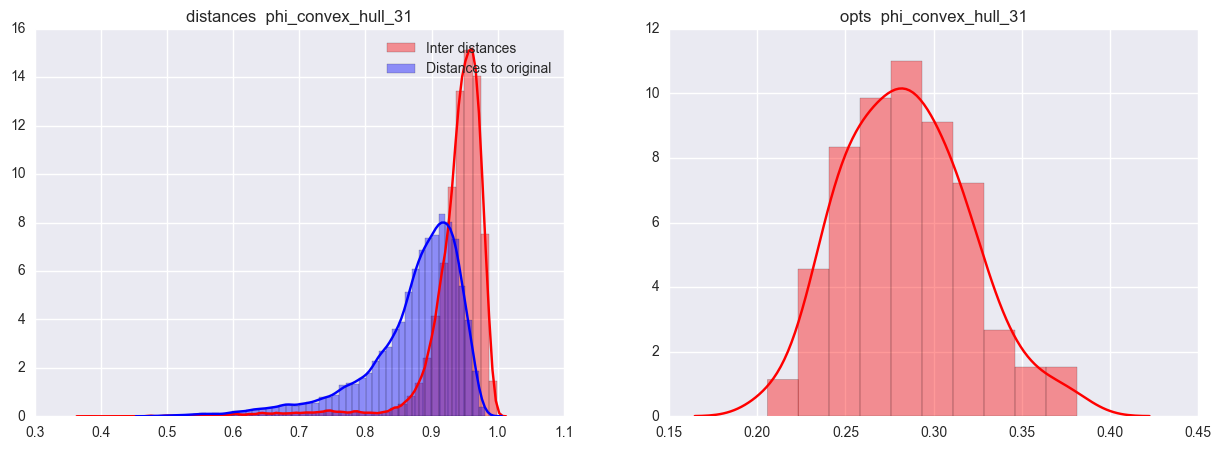

In [21]:
%matplotlib inline
indices = range(len(distances_to_original_list))
for idx in indices:
    plot_dists(distances_to_original_list[idx], inter_distances_list[idx], opt_res_to_original_list[idx], names[idx])

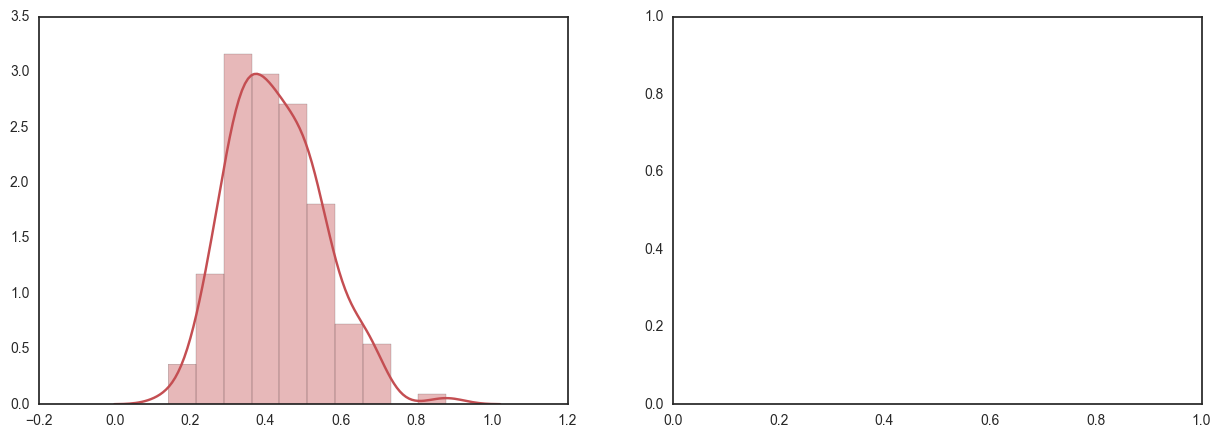

In [60]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
sns.distplot([val.x[0] for val in opt_res_to_original_list[idx].itervalues()], color='r', bins=10, ax=ax1)

In [29]:
# save_pickle_file(phi_convex_hull_1, 'phi_convex_hull_1')
# save_pickle_file(phi_convex_hull_2, 'phi_convex_hull_2')
# save_pickle_file(phi_convex_hull_3, 'phi_convex_hull_3')
# save_pickle_file(phi_convex_hull_4, 'phi_convex_hull_4')
# save_pickle_file(phi_convex_hull_5, 'phi_convex_hull_5')
# save_pickle_file(phi_convex_hull_6, 'phi_convex_hull_6')

In [238]:
# to do : save phi_convex on each iteration,
# make plot each iteration , save it
# разобраться почему 
# заодно сразу стабильность мерить
# спроектировать конечный результат на оригинальную 


[0, 2, 4, 6, 4, 9, 8, 7, 12, 7, 8, 9, 10, 10, 11, 15, 13, 13, 11, 13, 11, 15, 9, 13, 15, 15, 7, 11, 16, 8, 12, 11, 11, 18, 6, 10, 12, 11, 12, 13, 17, 15, 16, 11, 15, 12, 15, 14, 13, 15]


# Гранулярность

In [17]:
def get_phi_granularity(phi):
    return np.mean([get_words_close_to_th_count(col)[0] for topic, col in phi.iteritems()])
def get_words_close_to_th_count(col, global_th=0.95):
    cur_sum, sum_count = 0, 0
    for val in col.sort_values()[::-1]:
        if cur_sum + val <= global_th:
            cur_sum += val
            sum_count += 1
        else:
            break
    return sum_count, cur_sum

In [28]:
print('phi_original', get_phi_granularity(phi_original))
for idx, phi_convex in enumerate(phi_convex_hull_list):
    print(names[idx], get_phi_granularity(phi_convex))

('phi_original', 59.75)
('phi_convex_hull_1', 116.91666666666667)
('phi_convex_hull_2', 34.5625)
('phi_convex_hull_3', 49.428571428571431)
('phi_convex_hull_4', 16.208677685950413)
('phi_convex_hull_21', 133.64285714285714)
('phi_convex_hull_22', 38.891891891891895)
('phi_convex_hull_23', 45.789473684210527)
('phi_convex_hull_24', 16.351749539594845)
('phi_convex_hull_31', 129.61333333333334)


In [54]:
phi_convex_hull_tmp = phi_convex_hull_list[8]
cut_idx = 20
print phi_convex_hull_tmp.shape, get_phi_granularity(phi_convex_hull_tmp), phi_convex_hull_tmp.columns
print phi_convex_hull_tmp.iloc[:, 0:cut_idx].shape, get_phi_granularity(phi_convex_hull_tmp.iloc[:, 0:cut_idx])

(2216, 150) 129.613333333 Index([u'topic_19_0', u'topic_0_1', u'topic_3_2', u'topic_7_2', u'topic_12_2',
       u'topic_16_2', u'topic_17_2', u'topic_0_3', u'topic_10_3',
       u'topic_13_3',
       ...
       u'topic_15_46', u'topic_16_47', u'topic_18_47', u'topic_1_48',
       u'topic_10_48', u'topic_7_49', u'topic_8_49', u'topic_10_49',
       u'topic_12_49', u'topic_16_49'],
      dtype='object', length=150)
(2216, 20) 120.7


Попробуем подобрать create_model, чтобы granualirity была близка к original (=60), или хотя бы немного больше 60. 
Пока возьмем маленькое число итераций, потом увеличим.

In [92]:
def create_model_fn_20_reg_1(n_iteration):
    tmp_model = create_model(current_dictionary=dictionary, n_topics=20, n_doc_passes=5, seed_value=100 + n_iteration,
                            n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['ss_theta_regularizer'].tau = -0.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -0.5
    tmp_model = fit_one_model(tmp_model, _n_iterations=20, _model_name='model_20_reg_1_iter_{}'.format(n_iteration))
    return tmp_model
def create_model_fn_20_reg_2(n_iteration):
    tmp_model = create_model(current_dictionary=dictionary, n_topics=20, n_doc_passes=5, seed_value=100 + n_iteration,
                            n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['ss_theta_regularizer'].tau = -0.5
    tmp_model.regularizers['ss_phi_regularizer'].tau = -0.5
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = -10
    tmp_model = fit_one_model(tmp_model, _n_iterations=20, _model_name='model_20_reg_2_iter_{}'.format(n_iteration))
    return tmp_model
def create_model_fn_20_reg_3(n_iteration):
    tmp_model = create_model(current_dictionary=dictionary, n_topics=20, n_doc_passes=5, seed_value=100 + n_iteration,
                            n_top_tokens=15, p_mass_threshold=0.25)
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['@default_class']))
    tmp_model.regularizers['ss_theta_regularizer'].tau = -1 
    tmp_model.regularizers['ss_phi_regularizer'].tau = -1 
    tmp_model.regularizers['decorrelator_phi_regularizer'].tau = -10 
    tmp_model = fit_one_model(tmp_model, _n_iterations=20, _model_name='model_20_reg_3_iter_{}'.format(n_iteration))
    return tmp_model

In [16]:
OPT_FUN_THRESHOLD = 0.6
N_CLOSEST_TOPICS = 15
phi_convex_hull_20_reg_0, iterations_info_20_reg_0, iterations_filtering_info_20_reg_0 = build_convex_hull_with_filtering(
                                                     create_model_fn_1, 
                                                     get_topics_to_remove_by_opt_fun_and_distance, 
                                                     phi_original.index,
                                                     init_convex_hull=[], start_iteration=0,
                                                     max_iteration=15)
plot_convex_hull_topics_iterations_distribution(phi_convex_hull_20_reg_0)
plot_convex_hull_columns_change(iterations_info_20_reg_0)
save_pickle_file(phi_convex_hull_20_reg_0, 'phi_convex_hull_20_reg_0')
save_pickle_file(iterations_info_20_reg_0, 'iterations_info_20_reg_0')
print(get_phi_granularity(phi_convex_hull_20_reg_0))

[2017-02-18 16:08:39.952000] ********** iteration = 1 / 15
name = model_20_m1_iter_0, n_topics = 20, n_doc_passes = 5, seed_value = 100, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25

[2017-02-18 16:09:13.626000] filtering iteration = 1 / 15
[2017-02-18 16:09:20.670000] 0 topics to remove, 0 not_removed_topics_count because close topics, current convex_hull shape = (2216, 20)
[2017-02-18 16:09:20.670000] filtering iteration = 2 / 15
[2017-02-18 16:09:26.789000] 0 topics to remove, 0 not_removed_topics_count because close topics, current convex_hull shape = (2216, 20)
[2017-02-18 16:09:26.789000] topics to remove not increasing, breaking the for loop
[2017-02-18 16:09:26.790000] current convex_hull shape = (2216, 20)
[2017-02-18 16:09:26.790000] ********** iteration = 2 / 15
name = model_20_m1_iter_1, n_topics = 20, n_doc_passes = 5, seed_value = 101, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25

[2017-02-18 16:09:53.337000] filtering iteration = 1 / 15
[2017-02-1

C:\Users\Sheldon\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


NameError: name 'get_phi_granularity' is not defined

In [18]:
print(get_phi_granularity(phi_convex_hull_20_reg_0))

127.357142857


In [ ]:
OPT_FUN_THRESHOLD = 0.6
N_CLOSEST_TOPICS = 15
phi_convex_hull_20_reg_1, iterations_info_20_reg_1, iterations_filtering_info_20_reg_1 = build_convex_hull_with_filtering(
                                                     create_model_fn_20_reg_1, 
                                                     get_topics_to_remove_by_opt_fun_and_distance, 
                                                     phi_original.index,
                                                     init_convex_hull=[], start_iteration=0,
                                                     max_iteration=15)
plot_convex_hull_topics_iterations_distribution(phi_convex_hull_20_reg_1)
plot_convex_hull_columns_change(iterations_info_20_reg_1)
save_pickle_file(phi_convex_hull_20_reg_1, 'phi_convex_hull_20_reg_1')
save_pickle_file(iterations_info_20_reg_1, 'iterations_info_20_reg_1')
print(get_phi_granularity(phi_convex_hull_20_reg_1))

In [ ]:
OPT_FUN_THRESHOLD = 0.6
N_CLOSEST_TOPICS = 15
phi_convex_hull_20_reg_2, iterations_info_20_reg_2, iterations_filtering_info_20_reg_2 = build_convex_hull_with_filtering(
                                                     create_model_fn_20_reg_2, 
                                                     get_topics_to_remove_by_opt_fun_and_distance, 
                                                     phi_original.index,
                                                     init_convex_hull=[], start_iteration=0,
                                                     max_iteration=15)
plot_convex_hull_topics_iterations_distribution(phi_convex_hull_20_reg_2)
plot_convex_hull_columns_change(iterations_info_20_reg_2)
save_pickle_file(phi_convex_hull_20_reg_2, 'phi_convex_hull_20_reg_2')
save_pickle_file(iterations_info_20_reg_2, 'iterations_info_20_reg_2')
print(get_phi_granularity(phi_convex_hull_20_reg_2))

In [ ]:
OPT_FUN_THRESHOLD = 0.6
N_CLOSEST_TOPICS = 15
phi_convex_hull_20_reg_3, iterations_info_20_reg_3, iterations_filtering_info_20_reg_3 = build_convex_hull_with_filtering(
                                                     create_model_fn_20_reg_2, 
                                                     get_topics_to_remove_by_opt_fun_and_distance, 
                                                     phi_original.index,
                                                     init_convex_hull=[], start_iteration=0,
                                                     max_iteration=15)
plot_convex_hull_topics_iterations_distribution(phi_convex_hull_20_reg_3)
plot_convex_hull_columns_change(iterations_info_20_reg_3)
save_pickle_file(phi_convex_hull_20_reg_3, 'phi_convex_hull_20_reg_3')
save_pickle_file(iterations_info_20_reg_3, 'iterations_info_20_reg_3')
print(get_phi_granularity(phi_convex_hull_20_reg_3))

# Complex regulizators

In [77]:
def create_model_complex(current_dictionary, n_topics, n_doc_passes, seed_value, n_top_tokens, p_mass_threshold, _debug_print=False):    
    if _debug_print:
        print '[{}] creating model'.format(datetime.now())
    model = artm.ARTM(num_topics=n_topics, dictionary=current_dictionary, cache_theta=True, seed=seed_value, 
                  class_ids={'@default_class': 1.0})
    model.num_document_passes = n_doc_passes
    add_complex_scores_to_model(model, n_top_tokens=n_top_tokens, p_mass_threshold=p_mass_threshold)
    return model
def add_complex_scores_to_model(artm_model, n_top_tokens, p_mass_threshold,
    common_topics, subject_topics, _debug_print=False):
    if _debug_print:
        print '[{}] adding scores'.format(datetime.now())
    # subject
    artm_model.scores.add(artm.PerplexityScore(name='perplexity_score_subject', dictionary=dictionary,
                          topic_names=subject_topics))
    artm_model.scores.add(artm.SparsityPhiScore(name='ss_phi_score_subject', class_id='@default_class',
                          topic_names=subject_topics))
    artm_model.scores.add(artm.SparsityThetaScore(name='ss_theta_score_subject',
                          topic_names=subject_topics))
    artm_model.scores.add(artm.TopicKernelScore(name='topic_kernel_score_subject', class_id='@default_class', 
                          topic_names=subject_topics, probability_mass_threshold=p_mass_threshold))
    artm_model.scores.add(artm.TopTokensScore(name='top_tokens_score_subject', class_id='@default_class',
                          topic_names=subject_topics, num_tokens=n_top_tokens))
    
    # common
    artm_model.scores.add(artm.PerplexityScore(name='perplexity_score_common', dictionary=dictionary,
                          topic_names=common_topics))
    artm_model.scores.add(artm.SparsityPhiScore(name='ss_phi_score_common', class_id='@default_class',
                          topic_names=common_topics))
    artm_model.scores.add(artm.SparsityThetaScore(name='ss_theta_score_common',
                          topic_names=common_topics))
    artm_model.scores.add(artm.TopicKernelScore(name='topic_kernel_score_common', class_id='@default_class', 
                          topic_names=common_topics, probability_mass_threshold=p_mass_threshold))
    artm_model.scores.add(artm.TopTokensScore(name='top_tokens_score_common', class_id='@default_class', 
                          topic_names=common_topics, num_tokens=n_top_tokens))
def fit_one_model_complex(model, _n_iterations, _model_name='', _debug_print=False): 
    if _debug_print:
        print '[{}] fitting'.format(datetime.now())
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=_n_iterations)
    if _debug_print:
        print '[{}] outputting'.format(datetime.now())
#     printer.print_artm_model_complex(model, _model_name, _n_iterations, output_file=models_file)
#     model_pics_file_name =  path.join(config.experiment_path, _model_name)
#     plot_maker.make_tm_plots_complex(model, model_pics_file_name)
#     model_output_file_name = path.join(config.experiment_path, _model_name + '.txt')
#     printer.print_scores_complex(model, _model_name, _n_iterations, model_output_file_name)
#     printer.print_top_tokens_complex(model, model_output_file_name)
    return model
def create_model_fn_20_complex_reg_1(n_iteration):
    n_topics = 20
    common_topics = [u'topic_0', u'topic_1']
    subject_topics = list(set([u'topic_{}'.format(idx) for idx in range(2, 20)]) - set(common_topics))
    tmp_model = create_model_complex(current_dictionary=dictionary, n_topics=n_topics, n_doc_passes=5, seed_value=100 + n_iteration,
                            n_top_tokens=15, p_mass_threshold=0.25)
    # subject topics
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer_subject', 
        topic_names=subject_topics))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer_subject', 
        topic_names=subject_topics, class_ids=['@default_class']))
    tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer_subject', 
        topic_names=subject_topics, class_ids=['@default_class']))
    tmp_model.regularizers['ss_theta_regularizer_subject'].tau = -0.5
    tmp_model.regularizers['ss_phi_regularizer_subject'].tau = -0.5
    tmp_model.regularizers['decorrelator_phi_regularizer_subject'].tau = -10

    # common topics
    tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer_common', 
        topic_names=subject_topics))
    tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer_common', 
        topic_names=subject_topics, class_ids=['@default_class']))
#     tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer_common', 
#         topic_names=subject_topics, class_ids=['@default_class']))
    tmp_model.regularizers['ss_theta_regularizer_common'].tau = 0.5
    tmp_model.regularizers['ss_phi_regularizer_common'].tau = 0.5
#     tmp_model.regularizers['decorrelator_phi_regularizer_common'].tau = -10

    tmp_model = fit_one_model_complex(tmp_model, _n_iterations=20, _model_name='model_20_complex_reg_1_iter_{}'.format(n_iteration))
    return tmp_model

In [78]:
tmp_model = create_model_fn_20_complex_reg_1(1)

In [88]:
rm = tmp_model.score_tracker
rm

{'perplexity_score_subject': <artm.score_tracker.PerplexityScoreTracker at 0x14046828>,
 'ss_phi_score_subject': <artm.score_tracker.SparsityPhiScoreTracker at 0x140460b8>,
 'ss_theta_score_subject': <artm.score_tracker.SparsityThetaScoreTracker at 0x14046080>,
 'top_tokens_score': <artm.score_tracker.TopTokensScoreTracker at 0x140464e0>,
 'topic_kernel_score_subject': <artm.score_tracker.TopicKernelScoreTracker at 0x14046c18>}

In [87]:
type(rm['perplexity_score_subject']) is artm.score_tracker.PerplexityScoreTracker

True

In [90]:
type(rm['ss_theta_score_subject']) is artm.score_tracker.SparsityThetaScoreTracker 

True

In [79]:
phi = tmp_model.get_phi()

In [80]:
phi.columns

Index([u'topic_0', u'topic_1', u'topic_2', u'topic_3', u'topic_4', u'topic_5',
       u'topic_6', u'topic_7', u'topic_8', u'topic_9', u'topic_10',
       u'topic_11', u'topic_12', u'topic_13', u'topic_14', u'topic_15',
       u'topic_16', u'topic_17', u'topic_18', u'topic_19'],
      dtype='object')